# Analysis of mouse single cell hematopoietic populations - Hierarchical clustering of index sorted CMP
__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

raw data are available at

## Plate translations  

Plate|PlateID|SortDate|RunDate|Pop1|Pop2| 
-----|-------|--------|-------|----|----|
Plate1|LM_Plate1|01.03.19|02.15.19|CMP|MEP|  
Plate2|LM_Plate2|12.12.18|02.26.19|CMP|LSK|  
Plate3|LM_Plate3|01.03.19|03.06.19|MEP|CMP|  
Plate4|LM_Plate4|12.12.18|03.13.19|LSK|CMP|  
Plate5|LM_Plate5|01.10.19|03.18.19|LSK|LSK|  
Plate6|LM_Plate6|02.01.19|03.20.19|CMP|MEP|  
Plate7|LM_Plate7|02.01.19|08.06.19|MEP|CMP|  
Plate8|LM_Plate8|02.06.19|08.07.19|LSK|MEP|  
Plate9|LM_Plate9|01.23.19|08.09.19|LSK|MEP|  
Plate10|LM_Plate10|02.06.19|08.14.19|MEP|LSK|  
Plate11|LM_Plate11|01.23.19|08.19.19|MEP|LSK|  
Plate12|BP1|09.06.18|10.23.18|LSK|CMP|  
Plate13|BP2|09.06.18|10.23.18|CMP|LSK|  

## Workbook setup

## Load modules

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter, ExcelFile
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import savefig
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import re
from icecream import ic

## User-defined functions


In [2]:
def generate_probe_statistics(df, sheetname, writer):
    stats_table=pd.DataFrame()
    stats_table['Failed Probe'] = df.sum(axis=1)==0
    stats_table['sum'] = df.sum(axis=1).round(2)
    stats_table['min Ct'] = df.min(axis=1).round(2)
    stats_table['max Ct'] = df.max(axis=1).round(2)
    stats_table['mean Ct'] = biomark_ctIndexed.mean(axis=1).round(2)
    stats_table['median Ct'] = df.median(axis=1).round(2)
    stats_table['Ct std'] = df.std(axis=1).round(2)
    stats_table.to_excel(writer, sheetname)

In [3]:
def invert_ct(x):
    if x>0:
        return (1/x)
    else:
        return(0)

### apply_ct_limits

In [4]:
def apply_ct_limits(x, lowerlimit, upperlimit):
    if x < lowerlimit or x > upperlimit:
        return 0
    else:
        return x

### dCt

In [5]:
def dCt (plate, ref_list = ["Actb", "B2m", "Cd117"]):
    refCt = plate[plate[["Actb", "B2m", "Cd117"]] > 0].mean(axis = 1)
    plate = plate.subtract(refCt, axis = 0)
    return plate

### cell_filter

In [6]:
def cell_filter(plate, lowerlimit = 8, upperlimit = 40, min_passed_tests = 30, min_passed_references = 2, avg_ct = 20, transpose_plate = True):
    
    # Read plate
    plate.columns = ['Well ID', 'Probe', 'Ct']
    plate['Ct'] = plate['Ct'].replace(999.0, np.nan) # replace fails with NA
    
    # Filter cells
    plate['Ct'] = plate['Ct'].apply(lambda x: apply_ct_limits(x, lowerlimit, upperlimit)) # apply Ct threshold limits
    plate = plate.set_index(['Well ID', 'Probe']) # clean index
    plate = plate.unstack(level = 'Well ID') # clean index
    plate.columns = plate.columns.droplevel() # clean index
    plate = plate.transpose() # Sets cells to index
    plate = plate[plate[plate > 0].count(axis = 1) >= min_passed_tests] # Drop cells where fewer than X probes passed
    plate = plate[plate[plate[["Actb", "B2m", "Cd117"]] > 0].count(axis = 1) >= min_passed_references] # Drop cells where fewer than X reference probes passed
    plate = plate.replace(0, np.nan) # replace all 0 values with NA

    if transpose_plate == False:
        plate = plate.transpose()
    return plate

### probe_filter

In [7]:
def probe_filter(plate, pct_nan_allowed = .2):
    plate = plate.dropna(thresh=int(len(plate)*pct_nan_allowed), axis = 1)
    return plate

### dCt_xprsn

In [8]:
def dCt_xprsn(plate):
    plate = 2**(plate*-1)
    plate = plate.replace(np.nan, 0)
    return plate

### zscore_norm

In [9]:
def zscore_norm (plate):
    
    #Calculate z_score
    row_mean = plate.mean(axis = 1, skipna = True)
    row_std = plate.std(axis = 1, skipna = True)
    plate = plate.sub(row_mean, axis = 0)
    plate = plate.div(row_std, axis = 0)

    return plate

### flow_norm

In [10]:
def flow_norm(plate):
    
    # Calculate z_score (x - mean/stdev)
    column_mean = plate.mean(axis = 0, skipna = True)
    column_std = plate.std(axis = 0, skipna = True)
    plate = plate.sub(column_mean, axis = 1)
    plate = plate.div(column_std, axis = 1)
    
    # Replace 0 with NA
    plate = plate.replace(0, np.nan)
    return plate  

In [11]:
def binning_flow(indexStats_column):
    if indexStats_column.mean() !=0:
        flow_bins = [-np.inf, 0, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
        flow_labels = [0,1,2,3]
    elif indexStats_column.mean() == 0:
        if indexStats_column.std() ==0:
            flow_bins = [-np.inf, np.inf]
            flow_labels = [0]
        elif indexStats_column.std() !=0:
            flow_bins = [-np.inf, indexStats_column.mean(), indexStats_column.mean()+2*indexStats_column.std(), np.inf]
            flow_labels = [0, 1, 2]
    else:
        return
    binned_flow = pd.cut(indexStats_column, bins = flow_bins, labels = flow_labels)
    return pd.Series(binned_flow)

### assign_plate_id

In [12]:
def assign_plate_id(col, sortdate, sort_dict):
    pid = ''
    if sortdate in ['010319', '121218', '020119']:
        if any(col.str.contains('01')):
            pid = sort_dict[sortdate][0]
        elif any(col.str.contains('07')):
            pid = sort_dict[sortdate][1]
        else:
            pid = 'unknown'
    elif sortdate == '090618':
        if any(col.str.contains('01')):
            pid = sort_dict[sortdate][1]
        elif any(col.str.contains('07')):
            pid = sort_dict[sortdate][0]
        else:
            pid = 'unknown'
    else:
        pid = "notInSortList"
    return pid

In [13]:
heatmap_colors = sns.cubehelix_palette(n_colors = 10, start = 0.5, rot = -0.8, gamma = 0.6, hue = 1.00, light = .9, dark = 0, reverse = True)

# Biomark Data

## dCt normalization

Using deltaCt method:  
> refGenes = Act, B2m, Cd117  
> refCt = average(Actb, B2m, Cd117) (for refGenes > 0)  
> deltaCt(gene) = Ct(gene) - refCt  

### Read and filter data

Open every sheet in excel file, keep only rows where name contains CMP, then do processing

In [14]:
excel_biomark = pd.ExcelFile("/Users/heustonef/Desktop/Github/MouseSingleCellPaper/BioMark_CT.xlsx")

biomark_list = []
for sheet in excel_biomark.sheet_names:
    plate_data = pd.read_excel(excel_biomark, sheet_name=sheet, skiprows=11, usecols="B, E, G")
    plate_data = plate_data[plate_data["Name"].str.contains("CMP")]
    if not plate_data.empty:
        plate_data["Name"] = plate_data["Name"] + '_' + ''.join(re.search('(\w)[a-zA-Z]*(\d+)', sheet).groups([0, 2])).lower()
        plate_data = cell_filter(plate_data)
        plate_data = dCt(plate_data)
        biomark_list.append(plate_data)
        
biomark_ct = pd.concat(biomark_list, axis = 0, ignore_index = False)
biomark_ct = probe_filter(biomark_ct, pct_nan_allowed=0.2)

print("Number of cells:", biomark_ct.shape[0])
print("Number of probes:", biomark_ct.shape[1])
biomark_ct

Number of cells: 155
Number of probes: 75


,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd27,...,S100a11,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,1.589369,-0.444673,1.169116,NaN,3.634062,0.332199,1.635215,0.444673,NaN,0.455381,...,2.541631,0.594349,3.132360,5.714941,4.746246,3.408621,-0.303430,-0.612730,0.031598,0.820223
CMP_a2_p1,-0.731114,NaN,-1.578193,0.194122,NaN,-0.706782,1.001546,-0.194122,NaN,-0.997752,...,1.549698,NaN,1.949196,NaN,6.076568,NaN,1.705389,-3.555189,-1.563135,0.647836
CMP_a4_p1,2.310976,0.704268,-1.933065,1.704029,NaN,1.086256,-2.891958,-2.408297,NaN,-1.461956,...,2.372872,-2.757817,0.771059,NaN,5.486651,1.492772,-1.643035,0.611175,2.700474,1.609025
CMP_a5_p1,1.136514,-1.614311,7.067439,NaN,-0.311105,NaN,4.197377,1.614311,4.180689,0.753451,...,2.425638,0.436934,3.211972,NaN,11.962725,-0.682602,NaN,-0.929995,-0.119930,1.329137
CMP_b2_p1,18.047457,NaN,NaN,1.234380,NaN,NaN,NaN,-1.234380,3.026247,4.375826,...,7.499945,1.114829,NaN,NaN,NaN,9.685335,4.201488,9.359041,-0.459170,17.160924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_g6_p13,0.624140,0.280044,-2.636415,2.433573,NaN,NaN,NaN,-2.713617,2.581006,-0.115405,...,0.685619,-3.983376,1.498361,11.597984,4.181229,0.331962,-0.458829,0.594168,-0.301743,-1.064100
CMP_h1_p13,5.557299,1.972160,-6.758817,0.596678,NaN,3.814202,3.402576,-2.568838,NaN,1.983264,...,1.205645,4.151875,0.726473,NaN,5.795252,3.785482,1.062196,-1.042631,-0.844836,0.815569
CMP_h2_p13,3.411598,-0.550759,-5.855815,-0.069007,5.715312,2.552529,3.694601,0.619765,5.556135,2.644341,...,1.934823,-1.035313,1.373387,NaN,NaN,4.676205,0.327415,-1.436341,0.788520,0.309274


So deltaCt method normalizes individual cells to reference genes, so plate normalization is not necessary.  
Probe filtering has removed uninformative probes.  
For the moment let's ignore flow data (which probably has to be reanalyzed) and cluster just the cells

### Convert Ct values to expression

#### 2^-dCt

Delta delta Ct needs comparison against a control, but we don't have (i.e.,) treated vs untreated. Could use ref genes again, but this is probably double-normalizing.  
Let's just do expression of the dCts

In [15]:
biomark_ct = dCt_xprsn(biomark_ct)
biomark_ct

,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd27,...,S100a11,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,0.332317,1.361005,0.444694,0.000000,0.080545,0.794325,0.321922,0.734751,0.000000,0.729317,...,0.171748,0.662343,0.114042,0.019038,0.037260,0.094168,1.234075,1.529150,0.978336,0.566354
CMP_a2_p1,1.659921,0.000000,2.985956,0.874105,0.000000,1.632160,0.499465,1.144028,0.000000,1.996887,...,0.341582,0.000000,0.258961,0.000000,0.014817,0.000000,0.306639,11.754893,2.954952,0.638237
CMP_a4_p1,0.201524,0.613754,3.818655,0.306928,0.000000,0.470982,7.422770,5.308475,0.000000,2.754815,...,0.193061,6.763721,0.585987,0.000000,0.022303,0.355329,3.123221,0.654663,0.153843,0.327820
CMP_a5_p1,0.454857,3.061654,0.007456,0.000000,1.240657,0.000000,0.054508,0.326621,0.055143,0.593183,...,0.186127,0.738703,0.107920,0.000000,0.000251,1.605032,0.000000,1.905270,1.086682,0.398006
CMP_b2_p1,0.000004,0.000000,0.000000,0.425025,0.000000,0.000000,0.000000,2.352803,0.122746,0.048167,...,0.005524,0.461746,0.000000,0.000000,0.000000,0.001215,0.054353,0.001523,1.374751,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_g6_p13,0.648806,0.823566,6.217845,0.185106,0.000000,0.000000,0.000000,6.559641,0.167124,1.083279,...,0.621739,15.816690,0.353955,0.000323,0.055122,0.794456,1.374426,0.662427,1.232633,2.090866
CMP_h1_p13,0.021237,0.254871,108.294570,0.661275,0.000000,0.071090,0.094563,5.933313,0.000000,0.252917,...,0.433576,0.056255,0.604379,0.000000,0.018008,0.072520,0.478902,2.059980,1.796061,0.568184
CMP_h2_p13,0.093974,1.464856,57.912969,1.048994,0.019034,0.170456,0.077235,0.650777,0.021254,0.159946,...,0.261553,2.049558,0.385984,0.000000,0.000000,0.039113,0.796963,2.706337,0.578938,0.807048


##### Hierarchical clustering

Optional clustering methods:  
> single  
> complete  
> average  
> weighted  
> centroid  
> median  
> ward  

A note about z_scores:  
> Z scores are: z = (x - mean)/std, so values in each row (column) will get the mean of the row (column) subtracted, then divided by the standard deviation of the row (column).  
> This ensures that each row (column) has mean of 0 and variance of 1.  

Either 0 (rows) or 1 (columns):  
> 0 = Set the mean of each __gene__ to zero and see which cells express it the most  
> 1 = Set the mean of each __cell__ to zero and see which genes are most variable in it  

In [722]:
data = biomark_ct.transpose()

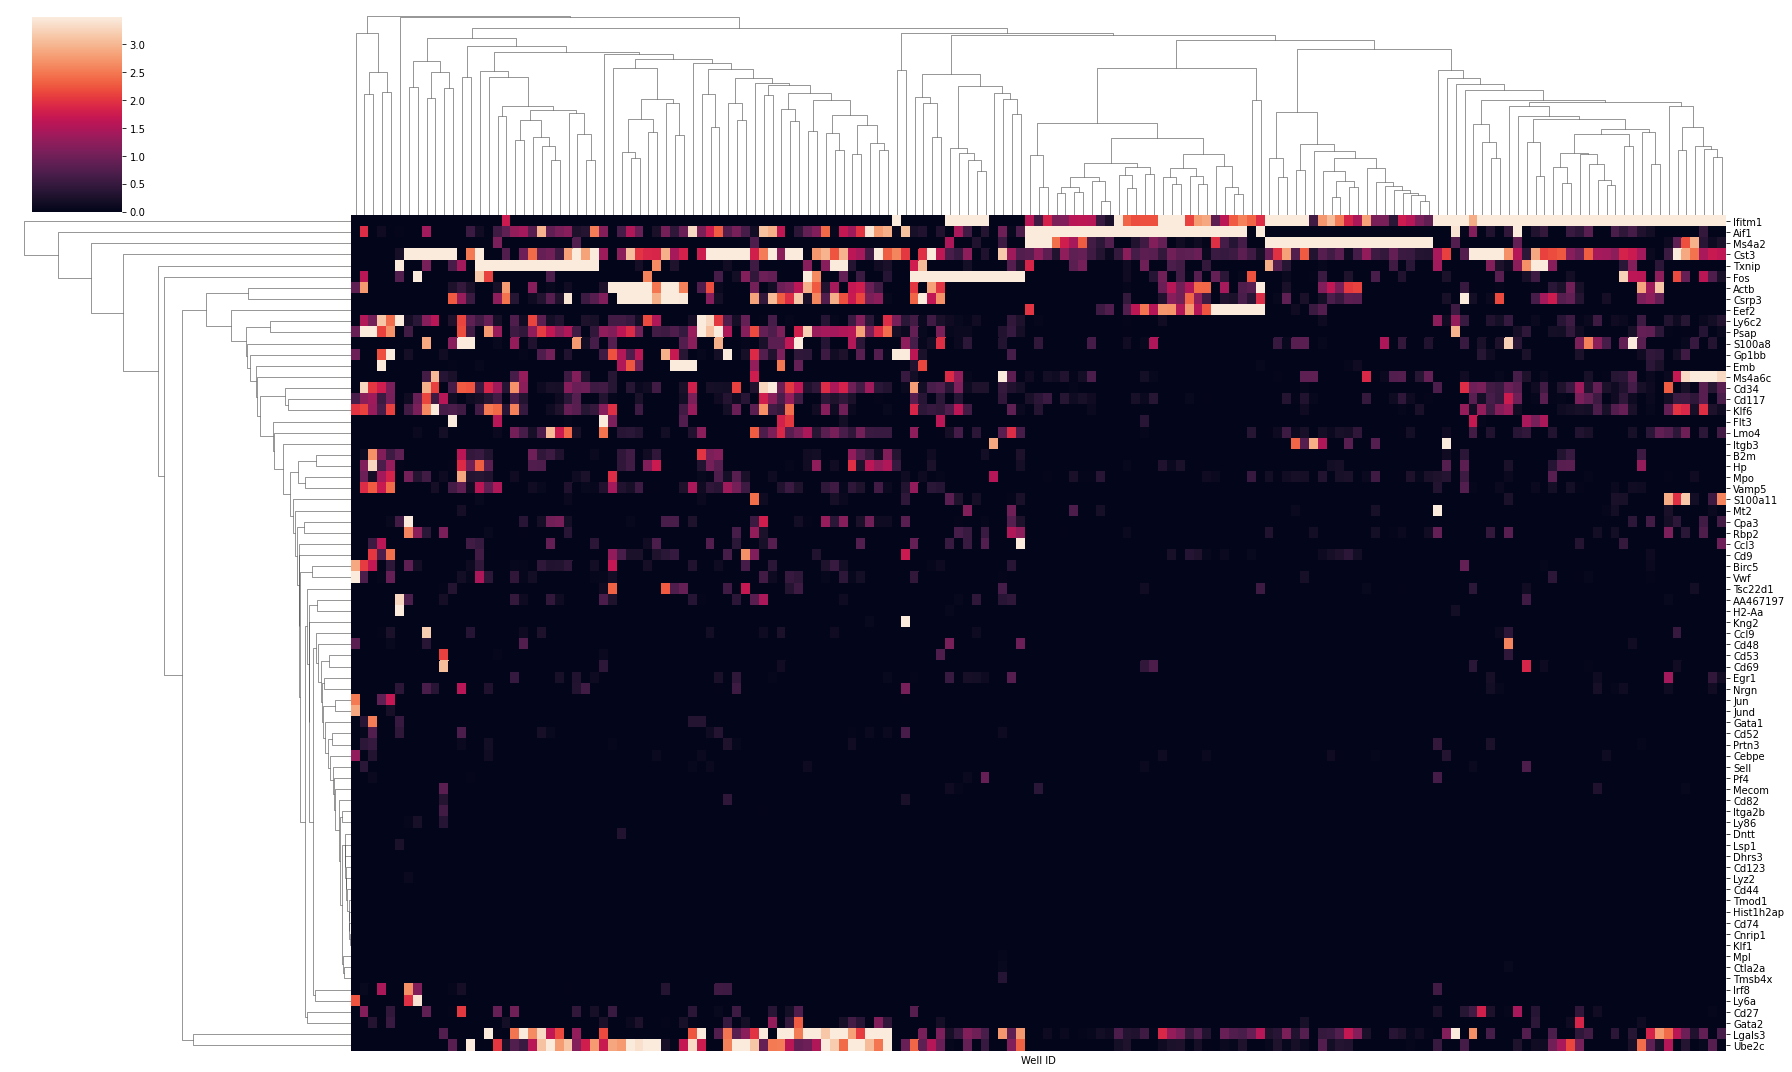

In [723]:
sns.clustermap(data, figsize=(25,15), method = 'average', robust = True, xticklabels = False, yticklabels = True, z_score = 1, vmin = 0)

Can color individual leaves to show which markers correspond with which celltypes  
https://python-graph-gallery.com/405-dendrogram-with-heatmap-and-coloured-leaves/

## Z_score norm

Z score across cells.  
Do you do z_score then dCt, or dCt then z_score, or just z_score?  
I think z_score is the cell norm method, so will try just z_score

### Read and filter data

In [14]:
excel_biomark = pd.ExcelFile("/Users/heustonef/Desktop/Github/MouseSingleCellPaper/biomark_ct.xlsx")

biomark_list = []
for sheet in excel_biomark.sheet_names:
    plate_data = pd.read_excel(excel_biomark, sheet_name=sheet, skiprows=11, usecols="B, E, G")
    plate_data = plate_data[plate_data["Name"].str.contains("CMP")]
    if not plate_data.empty:
        plate_data["Name"] = plate_data["Name"] + '_' + ''.join(re.search('(\w)[a-zA-Z]*(\d+)', sheet).groups([0, 2])).lower()
        plate_data = cell_filter(plate_data)
        plate_data = zscore_norm(plate_data)
        biomark_list.append(plate_data)
        
biomark_zscore = pd.concat(biomark_list, axis = 0, ignore_index = False)
biomark_zscore = probe_filter(biomark_zscore, pct_nan_allowed=0.2)

print("Number of cells:", biomark_zscore.shape[0])
print("Number of probes:", biomark_zscore.shape[1])
biomark_zscore

Number of cells: 155
Number of probes: 75


Probe,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd27,...,S100a11,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,-0.425854,-0.989052,-0.542217,NaN,0.140293,-0.773947,-0.413160,-0.742805,NaN,-0.739840,...,-0.162186,-0.701362,0.001379,0.716459,0.448241,0.077871,-0.949944,-1.035585,-0.857179,-0.638820
CMP_a2_p1,-0.691602,NaN,-1.008800,-0.345137,NaN,-0.682490,-0.042788,-0.490519,NaN,-0.791447,...,0.162474,NaN,0.312070,NaN,1.857610,NaN,0.220774,-1.749108,-1.003161,-0.175239
CMP_a4_p1,0.269754,-0.173608,-0.901366,0.102270,NaN,-0.068201,-1.165967,-1.032503,NaN,-0.771366,...,0.286834,-1.128951,-0.155178,NaN,1.146063,0.043975,-0.821333,-0.199297,0.377233,0.076054
CMP_a5_p1,-0.499742,-1.053757,0.694742,NaN,-0.791292,NaN,0.116713,-0.403514,0.113352,-0.576891,...,-0.240114,-0.640637,-0.081747,NaN,1.680649,-0.866111,NaN,-0.915936,-0.752789,-0.460948
CMP_b2_p1,2.217931,NaN,NaN,-0.535643,NaN,NaN,NaN,-0.939966,-0.242179,-0.021151,...,0.490504,-0.555223,NaN,NaN,NaN,0.848418,-0.049703,0.794979,-0.813006,2.072739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMP_g6_p13,-0.291295,-0.359692,-0.939409,0.068374,NaN,NaN,NaN,-0.954755,0.097680,-0.438297,...,-0.279074,-1.207151,-0.117522,1.890023,0.415763,-0.349372,-0.506561,-0.297253,-0.475337,-0.626874
CMP_h1_p13,1.120464,0.099841,-2.385707,-0.291733,NaN,0.624236,0.507054,-1.192897,NaN,0.103002,...,-0.118372,0.720365,-0.254783,NaN,1.188204,0.616060,-0.159209,-0.758414,-0.702106,-0.229419
CMP_h2_p13,0.522258,-0.676318,-2.281048,-0.530592,1.219110,0.262398,0.607864,-0.322245,1.170961,0.290170,...,0.075547,-0.822891,-0.094282,NaN,NaN,0.904790,-0.410679,-0.944199,-0.271199,-0.416166


### Convert Ct values ot expression

#### 2^-dCt

In [15]:
biomark_zscore = dCt_xprsn(biomark_zscore)
biomark_zscore.head(2)

Probe,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd27,...,S100a11,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,1.343368,1.984881,1.456208,0.000000,0.907335,1.709942,1.331599,1.673426,0.0,1.66999,...,1.118981,1.626039,0.999045,0.608589,0.732936,0.947455,1.931798,2.049945,1.811493,1.557055
CMP_a2_p1,1.615076,0.000000,2.012236,1.270271,0.000000,1.604908,1.030103,1.404950,0.0,1.73081,...,0.893492,0.000000,0.805485,0.000000,0.275933,0.000000,0.858105,3.361506,2.004387,1.129151


##### Hierarchical clustering on expression

In [16]:
biomark = biomark_zscore.transpose()

No z score cuz that's already done

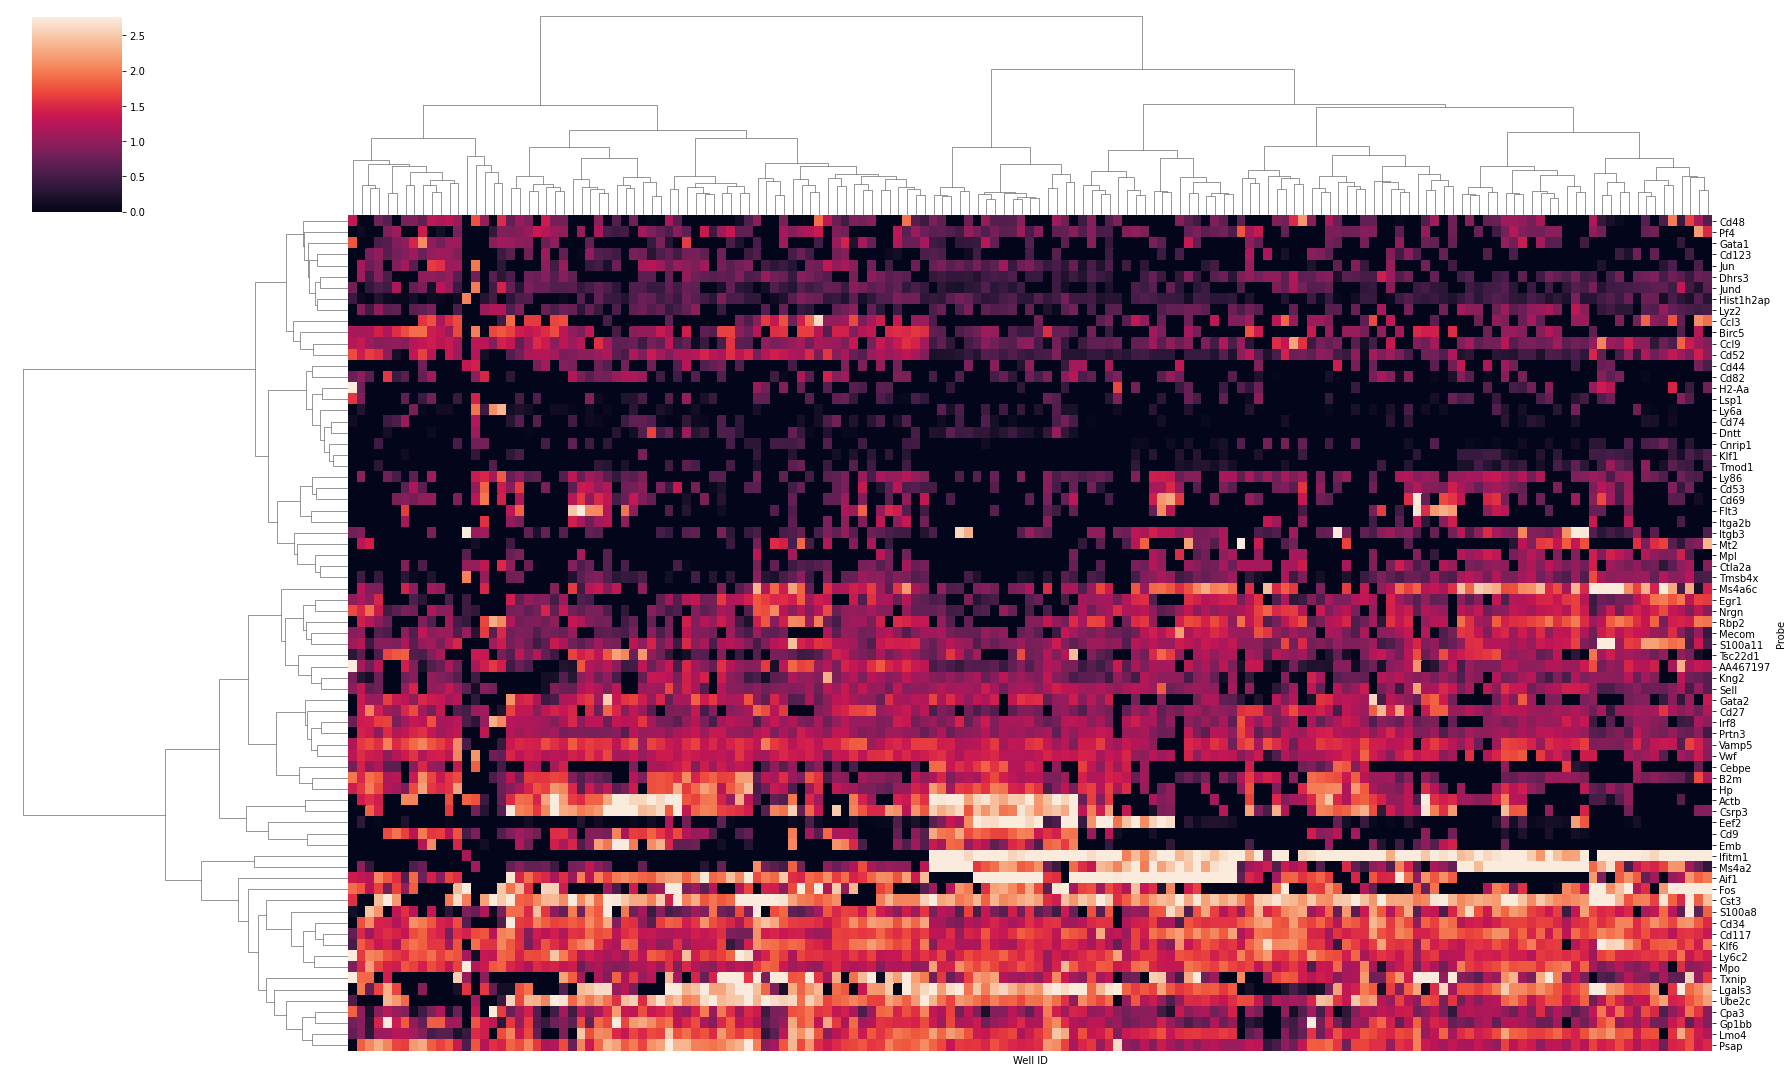

In [19]:
sns.clustermap(biomark, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0)

# Flow Data

## Thoughts...  
So what's the best way to normalize flow data? do you normalize by plate? Do you normalize by cell? Correct normalization will result in hierarchical clustering of cells that is _not_ driven by plate ID.  
We are comparing cells on the basis of their fluorescence intensity to each other.  
> z_score across cells measures mfi of one marker against another per cell. This doesn't let me compare cells to eachother, just markers to eac other.  
> z_score across each plate might make more sense. This accounts for different Ab lots between plates, but preserves the relative MFI of each antibody on each cell vs each other cell.  
> z_score across all plates would not correct for diff antibody efficiencies, it would just squish the differences into a z-score and cells would cluster based on plate and not cell  

Will do z_score across each plate, then normalize

### Literature notes

[Guidelines for the use of flow cytometry and cell sorting in immunological studies](https://onlinelibrary.wiley.com/doi/10.1002/eji.201646632)



## Read MFI data

Note that we dont' need the live/dead, so we'll drop that

Plate|PlateID|SortDate|RunDate|Pop1|Pop2| 
-----|-------|--------|-------|----|----|
Plate1|LM_Plate1|01.03.19|02.15.19|CMP|MEP|  
Plate2|LM_Plate2|12.12.18|02.26.19|CMP|LSK|  
Plate3|LM_Plate3|01.03.19|03.06.19|MEP|CMP|  
Plate4|LM_Plate4|12.12.18|03.13.19|LSK|CMP|  
Plate5|LM_Plate5|01.10.19|03.18.19|LSK|LSK|  
Plate6|LM_Plate6|02.01.19|03.20.19|CMP|MEP|  
Plate7|LM_Plate7|02.01.19|08.06.19|MEP|CMP|  
Plate8|LM_Plate8|02.06.19|08.07.19|LSK|MEP|  
Plate9|LM_Plate9|01.23.19|08.09.19|LSK|MEP|  
Plate10|LM_Plate10|02.06.19|08.14.19|MEP|LSK|  
Plate11|LM_Plate11|01.23.19|08.19.19|MEP|LSK|  
Plate12|BP1|09.06.18|10.23.18|LSK|CMP|  
Plate13|BP2|09.06.18|10.23.18|CMP|LSK|  

In [17]:
sort_dict = {'010319':['p1', 'p3'], 
            '121218': ['p2', 'p4'],
            '020119': ['p6', 'p7'],
            '090618': ['p12', 'p13'],
           }

#### Ab panel for CMP

Antibody|Fluor|Equivalencies|
--------|-----|-------------|
Cd36|SB780|BV786|
Flk2/Flt3/Cd135|PerCp-eFluor710|PerCpCy5.5|
Cd48|PE-Cy7|N/A|
Cd9|eFluor450|BV421/SB436|
Cd34|eFluor660|APC|
Cd123|PE|N/A|
cKit/Cd117|PE-eFluor610|PI|
Cd16/32|AF700|APC-Alexa700|
Cd41|Fitc|N/A|
Cd150|SB645|BV650|
Viability|eFluor506|AmCyan|

In [18]:
fluor_dict = {'FITC-A': 'Cd41', 
              'PerCP-A': 'Cd135', 
              'PE-A': 'Cd123', 
              'PE-Cy7-A': 'Cd48', 
              'APC-A': 'Cd34', 
              'APC-Alexa 700-A': 'Cd16/32', 
              'BV510-A': 'Viability', 
              'BV650-A': 'Cd150', 
              'BV786-A': 'Cd36', 
              'PI-A': 'Cd117',
              'PerCP-Cy5-5-A': 'Cd135',
              'BV421-A': 'Cd9',
              'BV750-A': 'Cd36', 
              'PE-CF594-A': 'Cd117', 
             }

### indexSort Plugin v3

This is new, with a new output format. Going to stuggle a bit to make this work

In [19]:
os.chdir("/Users/heustonef/Desktop/CMPSubpops/FlowData/")

In [20]:
plates_01_03 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/010319 EH CMP extended violet panel/"
plates_02_04 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/121218 EH CMP extended violet panel/"
plates_12_13 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/090618 CMP Ext Vio FWDS 070/"
plates_06_07 = "/Users/heustonef/Desktop/CMPSubpops/FlowData/020119 EH CMP extended violet panel/"

cmp_plates = [plates_01_03, plates_02_04, plates_06_07, plates_12_13]

In [21]:
list_of_files = []
for plate in cmp_plates:
    for (dirpath, dirnames, filenames) in os.walk(plate):
        for filename in filenames:
            if filename.endswith('Well.csv'): 
                list_of_files.append(os.sep.join([dirpath, filename]))

In [22]:
mfi = pd.DataFrame()
mfi_list = []

for file in list_of_files:
    df = pd.read_csv(file, usecols=[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
    df = df.rename(columns = fluor_dict)
    sortdate = re.search('(^\d+).*(\d{3}_\d{3})', os.path.basename(file)).group(1)
    plateid = re.search('(^\d+).*(\d{3}_\d{3})', os.path.basename(file)).group(2)
#     ic(sortdate, df.columns)
    pid = assign_plate_id(df.Well, sortdate, sort_dict)
    df['sortdate'] = sortdate
    df['plateid'] = plateid
    df['pid'] = pid
    df['Well'] = df['Well'].str.lower()
    mfi_list.append(df)
mfi = pd.concat(mfi_list, axis = 0, ignore_index=True)

mfi = mfi.sort_values(['sortdate', 'Well', 'plateid'])
mfi = mfi.drop_duplicates(subset = ['Well', 'sortdate'], keep = 'first')
mfi.index = 'CMP_' + (mfi['Well'].str.cat(mfi['pid'], sep = '_')).astype('str')
# mfi = mfi.drop(['Well', 'sortdate',  'plateid'], axis = 1)
# mfi = mfi.drop(['Cd16/32_AF700', 'Viability'], axis = 1)
mfi = mfi.drop(['Cd16/32', 'Viability'], axis = 1)
mfi.shape

(359, 13)

### Find and assign missing pids

In [23]:
unk_list = np.where(mfi.pid == 'unknown')[0].tolist()
unk_list

[139]

In [24]:
for unk in unk_list:
    print(unk)
    print(mfi.iloc[(unk-1):(unk+2), [0, 10, 11, 12]])

139
                Well sortdate  plateid      pid
Well                                           
CMP_d08_p7       d08   020119  002_015       p7
CMP_d09_unknown  d09   020119  003_016  unknown
CMP_d10_p7       d10   020119  002_015       p7


In [25]:
mfi = mfi.rename(index = {'CMP_d09_unknown': 'CMP_d09_p7'})
mfi.pid[139] = 'p7'

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
mfi.index[139]

'CMP_d09_p7'

### Hitogram of unmodified flow data

In [27]:
mfi.min()

Well                a01
Cd41        -579.446143
Cd135      -1285.242269
Cd9         -962.597792
Cd150      -2617.724712
Cd36        -5478.03776
Cd34         291.787665
Cd123      -1051.228852
Cd117        4648.65454
Cd48         109.133909
sortdate         010319
plateid         001_014
pid                  p1
dtype: object

In [28]:
mfi_by_pid = mfi.groupby('pid')
mfi_by_pid.groups.keys()

dict_keys(['p1', 'p12', 'p13', 'p2', 'p3', 'p4', 'p6', 'p7'])

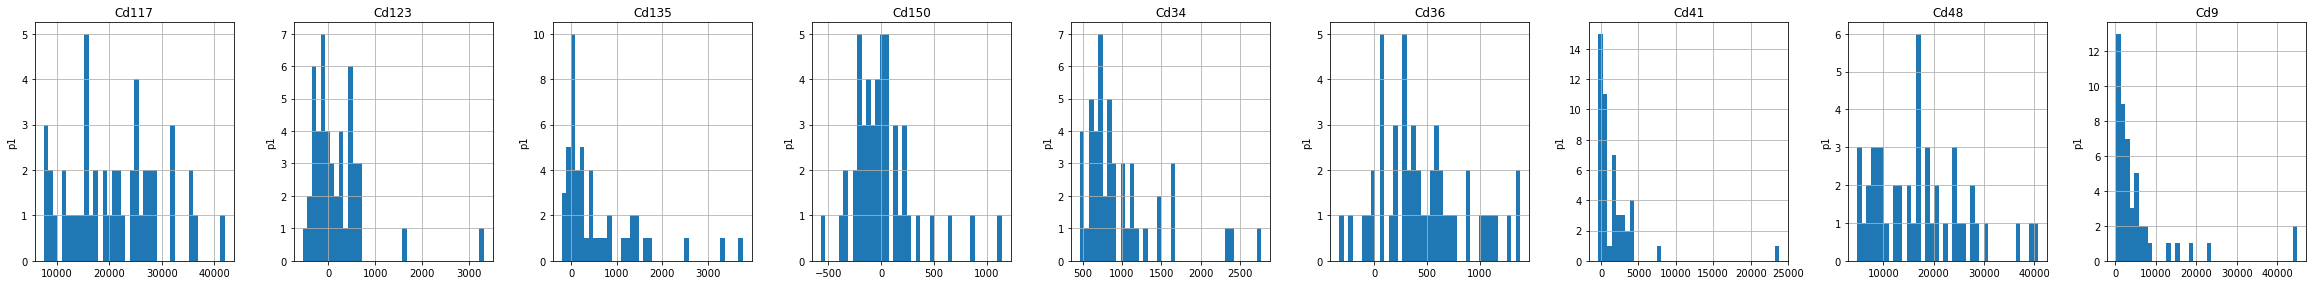

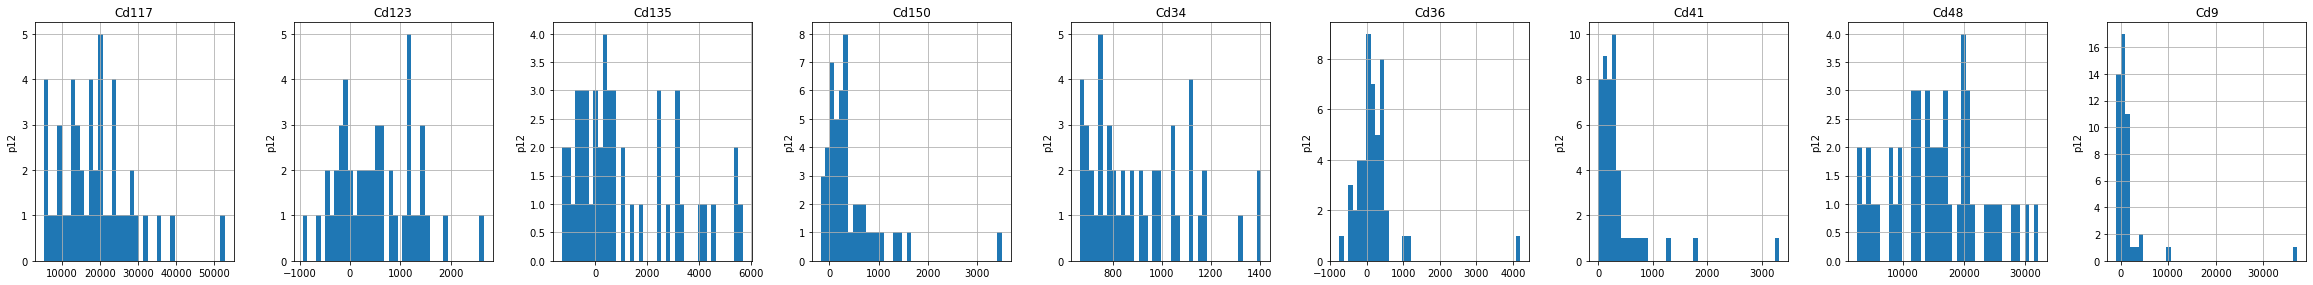

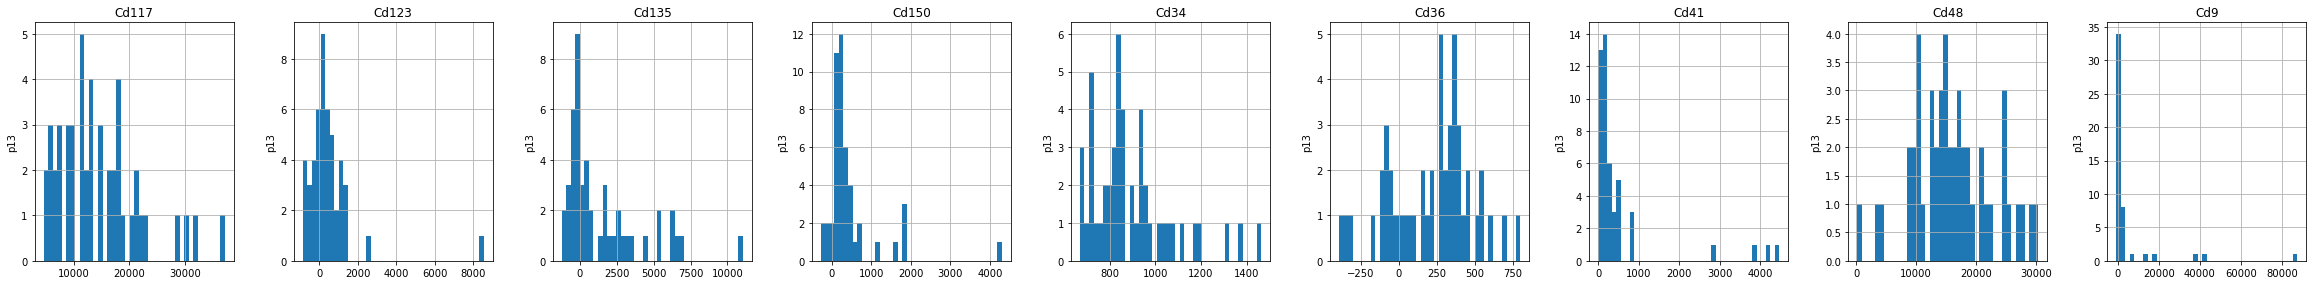

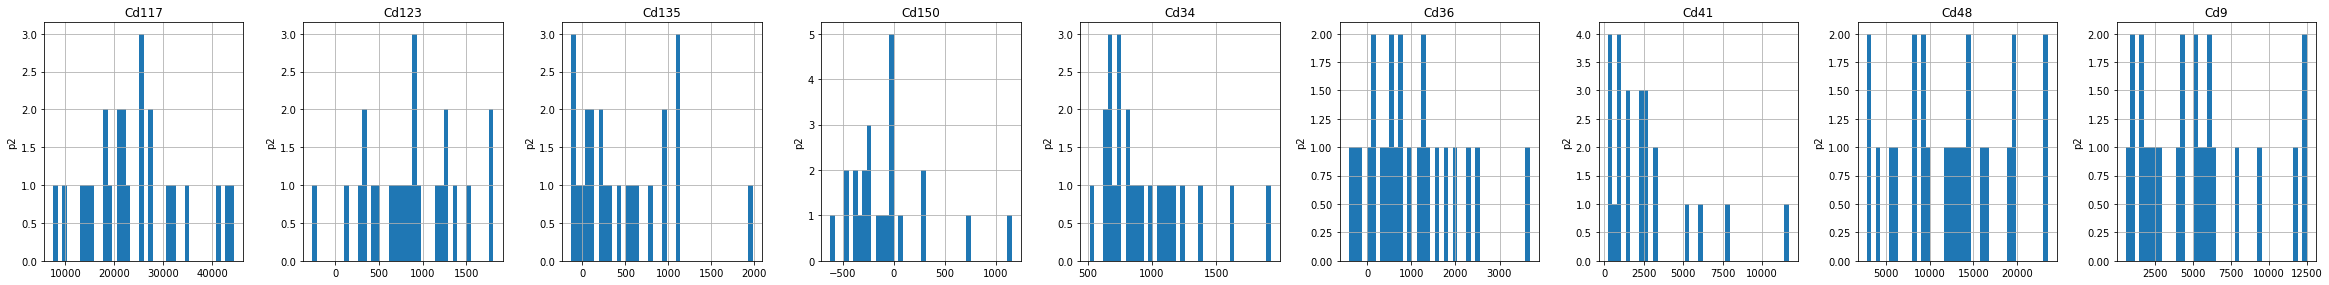

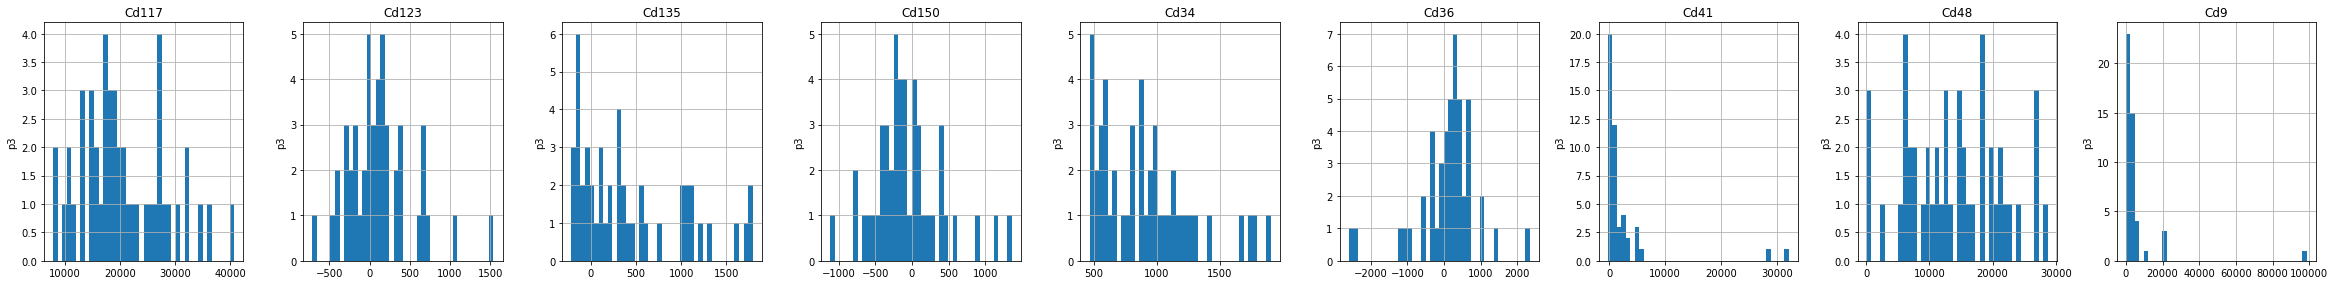

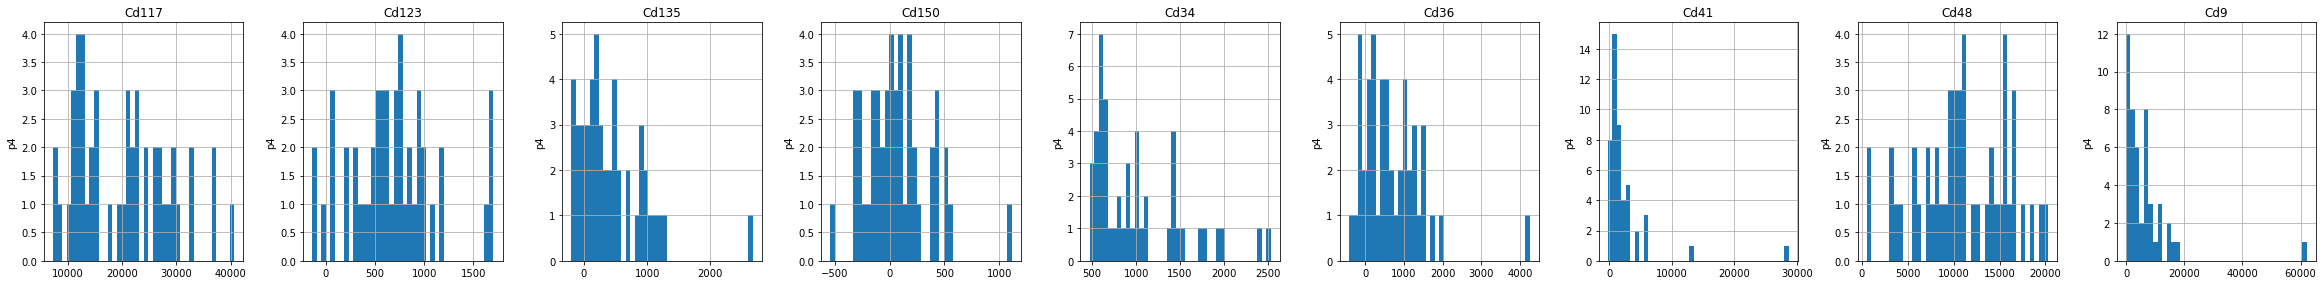

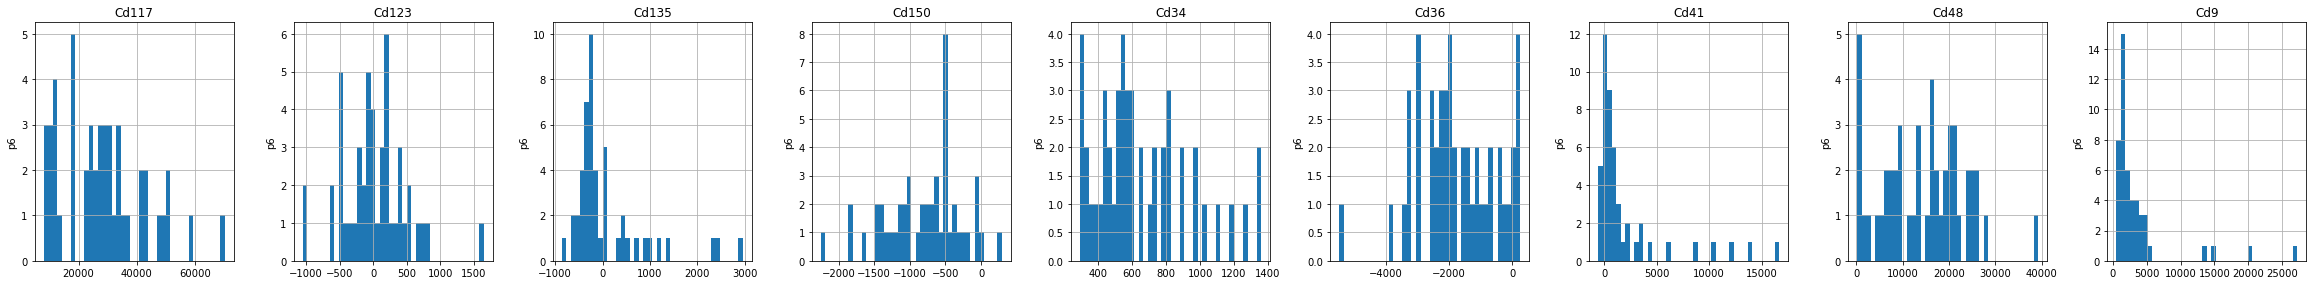

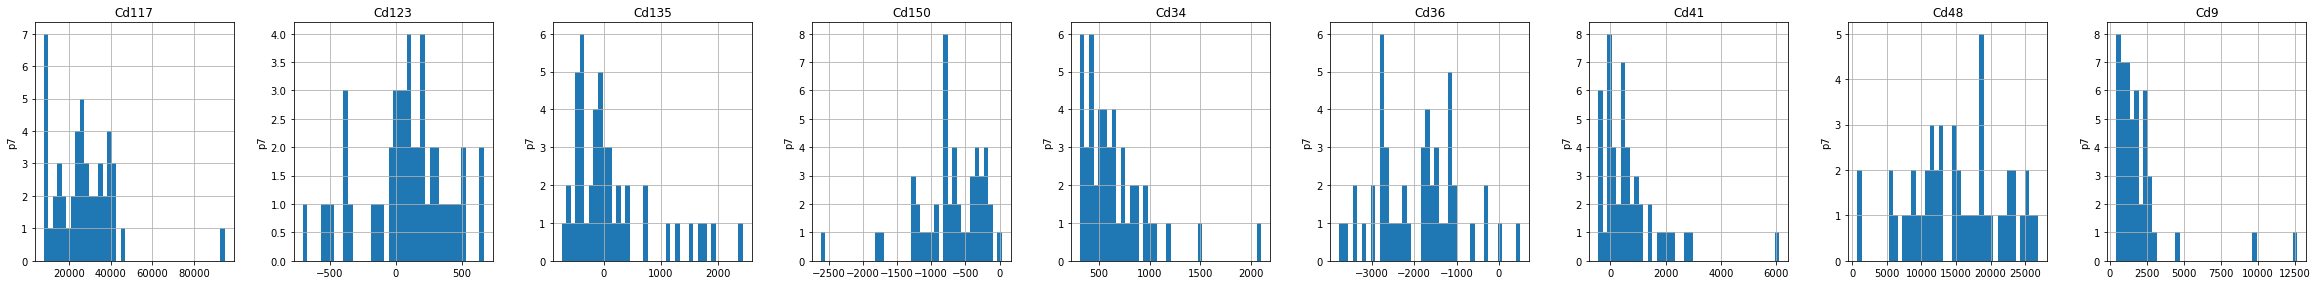

In [32]:
for plate in mfi_by_pid.groups.keys():
    plot_group = mfi_by_pid.get_group(plate)
    plot_group = plot_group.replace(np.nan, 0)
    
    for array in plot_group.hist(bins = 40, layout = (9, 11), figsize = (50, 50)):
        for subplot in array:
            subplot.set_ylabel(plate)
#             subplot.set_xlim(left = 0)


## Norm MFI data

### Z_score norm

#### Hierarchical cluster 

In [29]:
mfi = mfi_data.transpose()

NameError: name 'mfi_data' is not defined

No z score cuz that's already done

In [30]:
rdbu = sns.diverging_palette(250, 10, s = 100, l=50, sep = 1,  center= "dark", as_cmap=True)

### MFI above background

Problem with zscore norm is that it doesn't necessarily preserve fluourescence distribution  
Went throught each experiment and calculated minimum MFI that was still "positive" above background (i.e., Cd34 MFI 161 = Cd34- but Cd34 MFI 162 = Cd34+)  
For ease, going to just call this "background"  
Will subtract background from fluor for each experiment, then normalize between 1 and 100 <- this will preserve distribution of "positive" values

#### Define backgrounds for each experiment

In [32]:
bkgd_dict = {'010319': {'Cd34': 162, 'Cd117': 1200, 'Cd9': 1100, 'Cd36': 1300, 'Cd41': 433, 'Cd48': 89, 'Cd123': 314, 'Cd150': 415, 'Cd135': 433},
             '020119': {'Cd34': 222, 'Cd117': 356, 'Cd9': 1100, 'Cd36': 204, 'Cd41': 430, 'Cd48': 156, 'Cd123': 305, 'Cd150': 419, 'Cd135': 27},
             '090618': {'Cd34': 593, 'Cd117': 419, 'Cd9': 376, 'Cd36': 828, 'Cd41': 431, 'Cd48': 197, 'Cd123': 960, 'Cd150': 618, 'Cd135': 1000},
             '121218': {'Cd34': 205, 'Cd117': 454, 'Cd9': 593, 'Cd36': 1300, 'Cd41': 755, 'Cd48': 91, 'Cd123': 1600, 'Cd150': 439, 'Cd135': 445}
            }

In [33]:
mfi_by_sortdate = mfi.groupby('sortdate')
mfi_by_sortdate.get_group('010319').head(2)

,Well,Cd41,Cd135,Cd9,Cd150,Cd36,Cd34,Cd123,Cd117,Cd48,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a01_p1,a01,2016.948658,16.446109,1303.250688,-68.335742,75.990236,1167.851376,227.502089,14971.870215,18679.358359,010319,002_015,p1
CMP_a02_p1,a02,1082.874354,-119.097785,3392.294714,-230.959468,576.649347,1035.059705,620.126886,35875.575697,21949.353988,010319,002_015,p1


In [34]:
mfi_sortdate_list = []

for sortdate in mfi_by_sortdate.groups.keys():
    mfi_subbkgd = mfi_by_sortdate.get_group(sortdate)
    sortdate_math = bkgd_dict[sortdate]
    for fluor in sortdate_math.keys():
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor] - sortdate_math[fluor] # sets min positive value to 0
#         ic(fluor, mfi_subbkgd[fluor].max())
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor].clip(lower = 0)
        mfi_subbkgd[fluor] = mfi_subbkgd[fluor]/mfi_subbkgd[fluor].max()
    
    mfi_sortdate_list.append(mfi_subbkgd)
mfi_sortdate = pd.concat(mfi_sortdate_list)

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [35]:
mfi_sortdate.head(2)

,Well,Cd41,Cd135,Cd9,Cd150,Cd36,Cd34,Cd123,Cd117,Cd48,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a01_p1,a01,0.049922,0.0,0.00208,0.0,0.0,0.38593,0.000000,0.337471,0.456239,010319,002_015,p1
CMP_a02_p1,a02,0.020482,0.0,0.02346,0.0,0.0,0.33498,0.101881,0.849703,0.536491,010319,002_015,p1


In [36]:
mfi_sortdate[mfi_sortdate['pid'] == 'p7'].max()

Well             h12
Cd41          0.3495
Cd135       0.823821
Cd9         0.441867
Cd150            NaN
Cd36             1.0
Cd34             1.0
Cd123       0.266368
Cd117            1.0
Cd48        0.683024
sortdate      020119
plateid      003_016
pid               p7
dtype: object

#### Histogram of corrected data

In [37]:
mfi_sortdate_by_pid = mfi_sortdate.groupby('pid')
temp = mfi_sortdate_by_pid.get_group('p1')
temp.head()

,Well,Cd41,Cd135,Cd9,Cd150,Cd36,Cd34,Cd123,Cd117,Cd48,sortdate,plateid,pid
Well,,,,,,,,,,,,,
CMP_a01_p1,a01,0.049922,0.000000,0.002080,0.000000,0.0,0.385930,0.000000,0.337471,0.456239,010319,002_015,p1
CMP_a02_p1,a02,0.020482,0.000000,0.023460,0.000000,0.0,0.334980,0.101881,0.849703,0.536491,010319,002_015,p1
CMP_a03_p1,a03,0.000000,0.353973,0.000000,0.000000,0.0,0.182818,0.000000,0.154764,0.420968,010319,002_015,p1
CMP_a04_p1,a04,0.125845,0.000000,0.174842,0.000000,0.0,0.279741,0.000000,0.281205,0.119243,010319,002_015,p1
CMP_a05_p1,a05,0.108291,0.000000,0.145999,0.771727,0.0,0.120034,0.025096,0.583794,0.155792,010319,002_015,p1


In [113]:
# sns.set(rc={'figure.figsize':(12.7,8.6)})


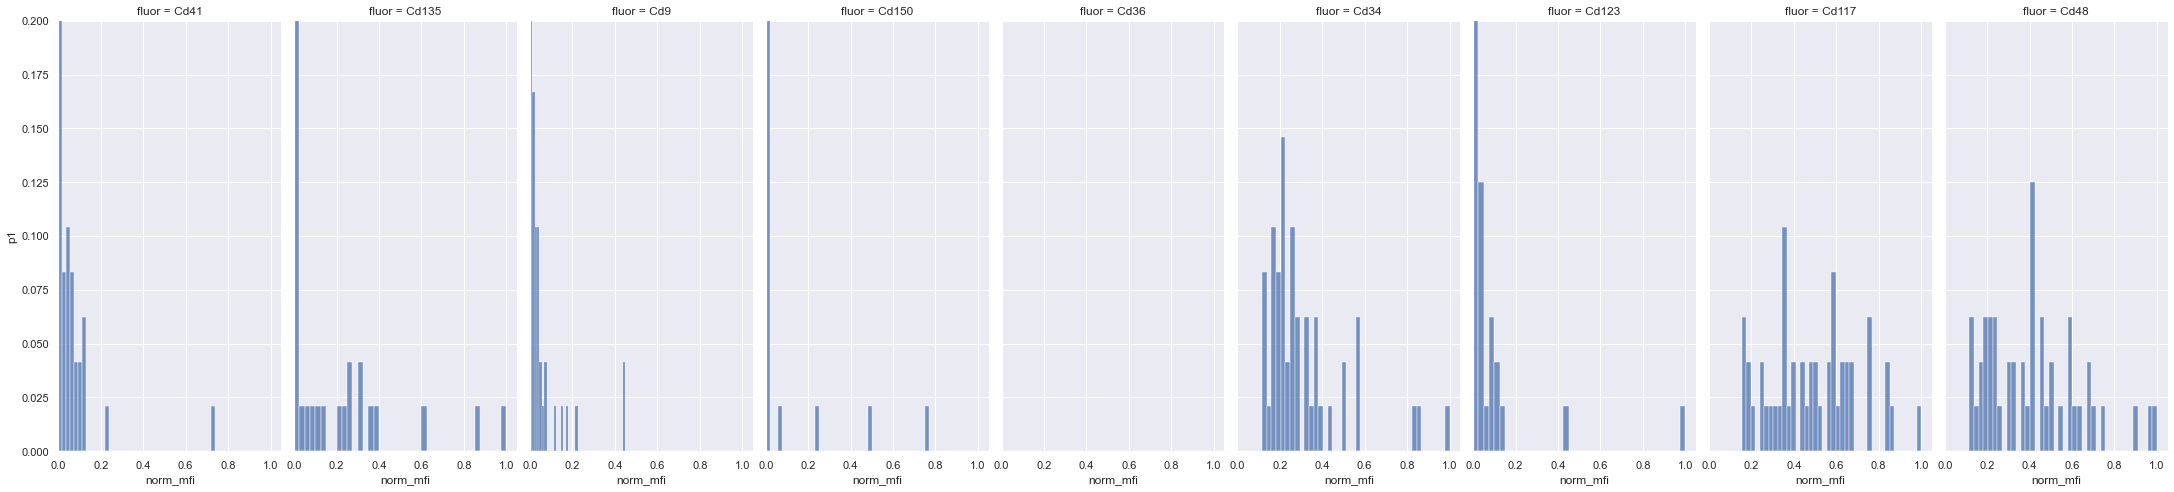

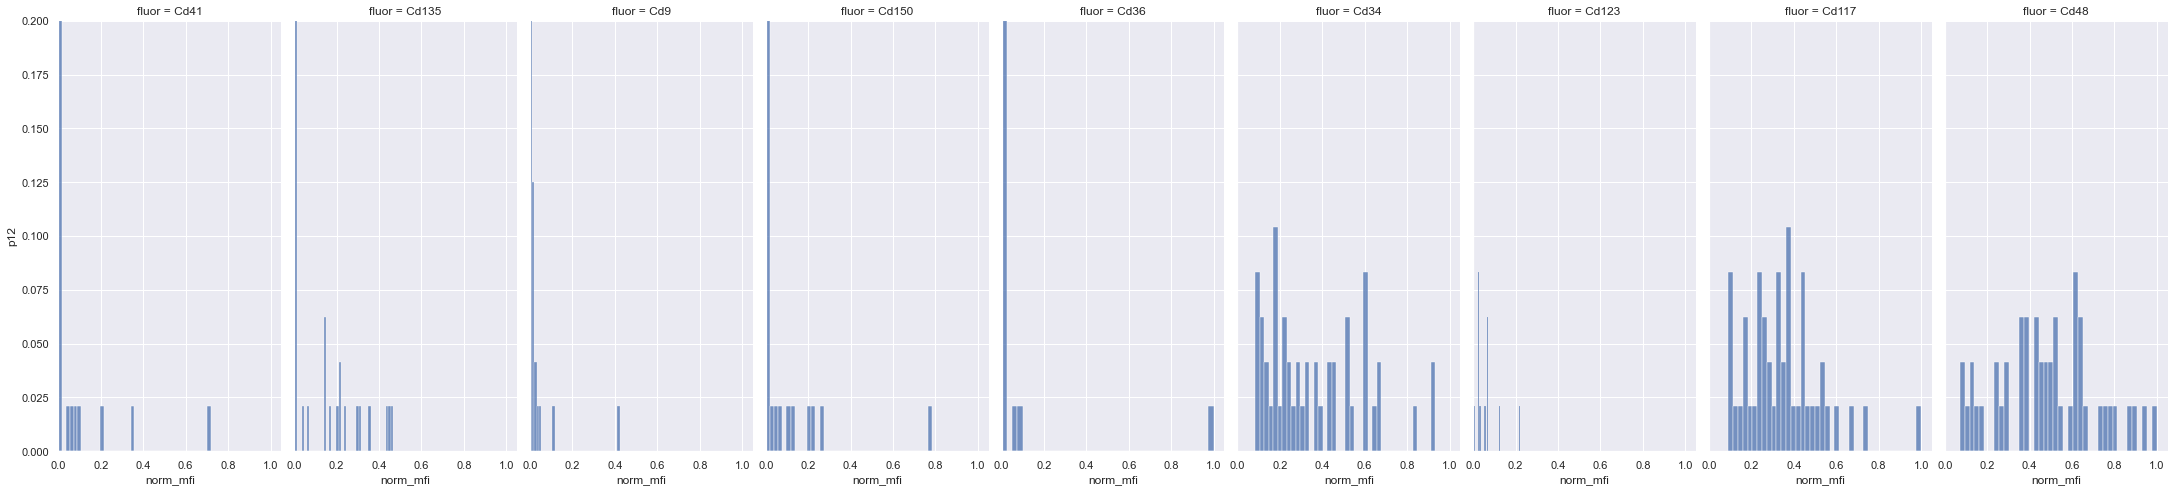

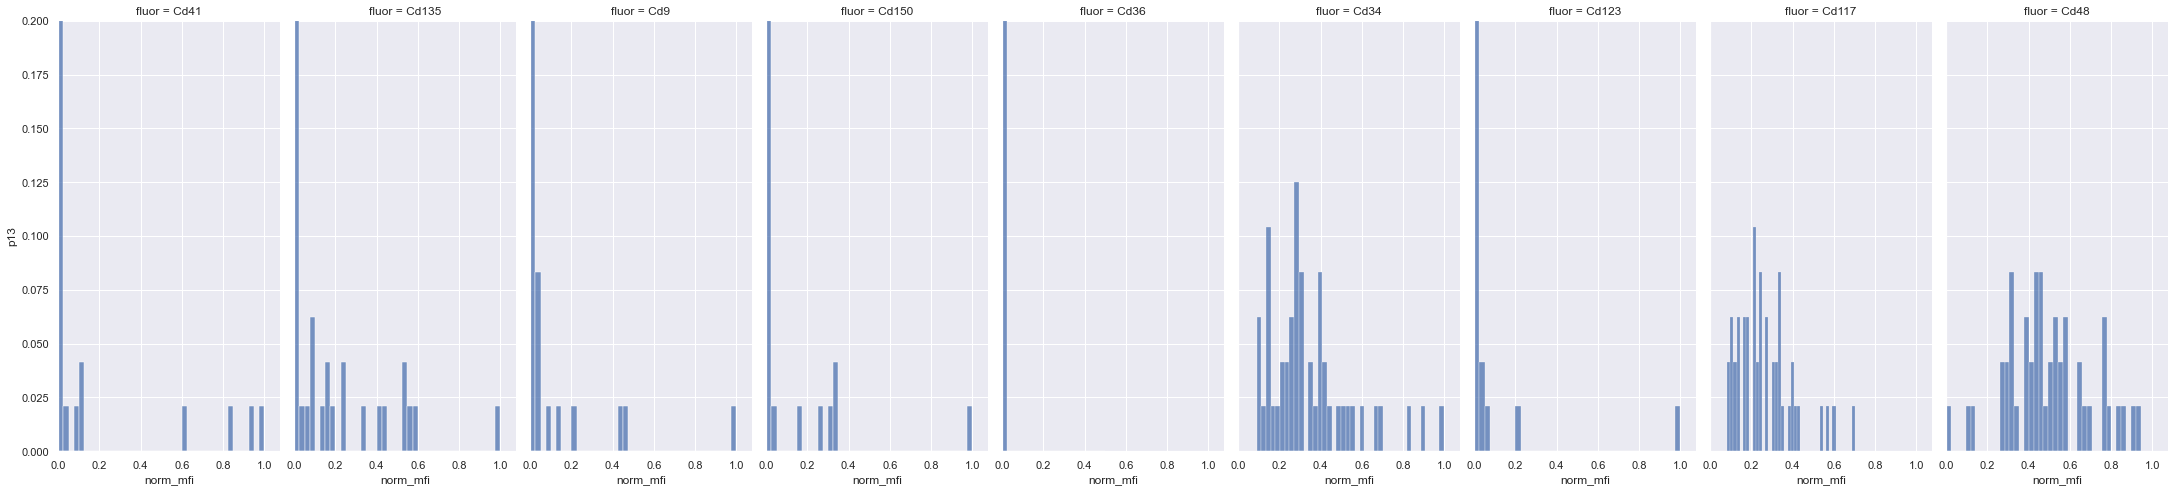

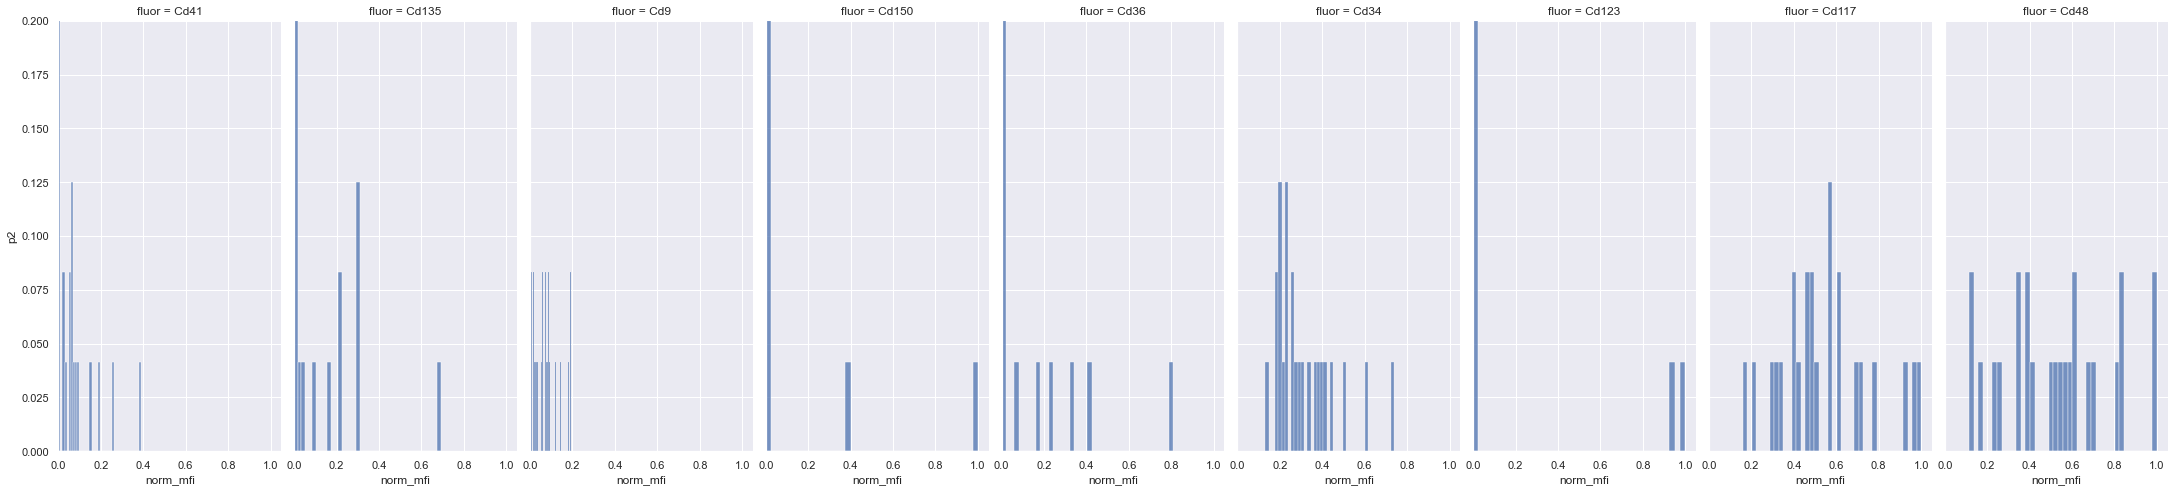

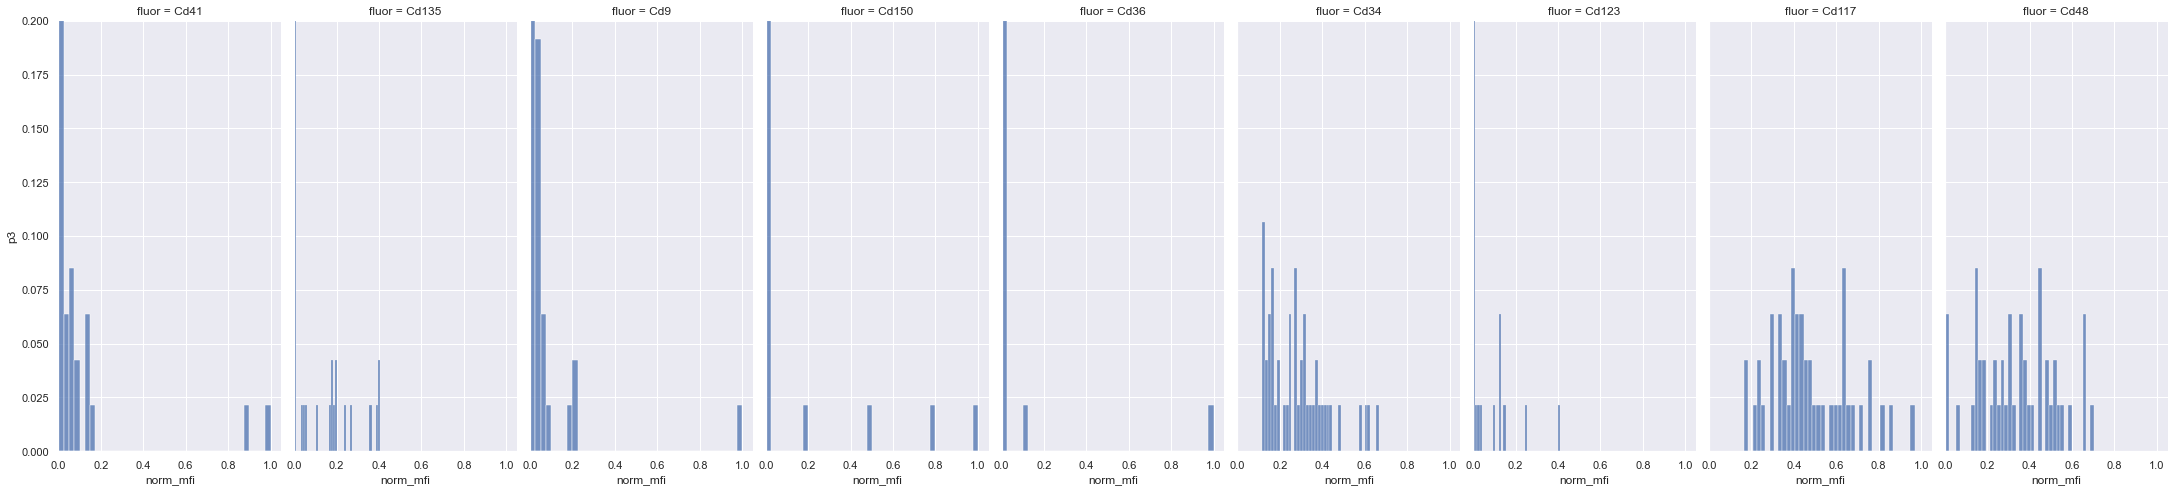

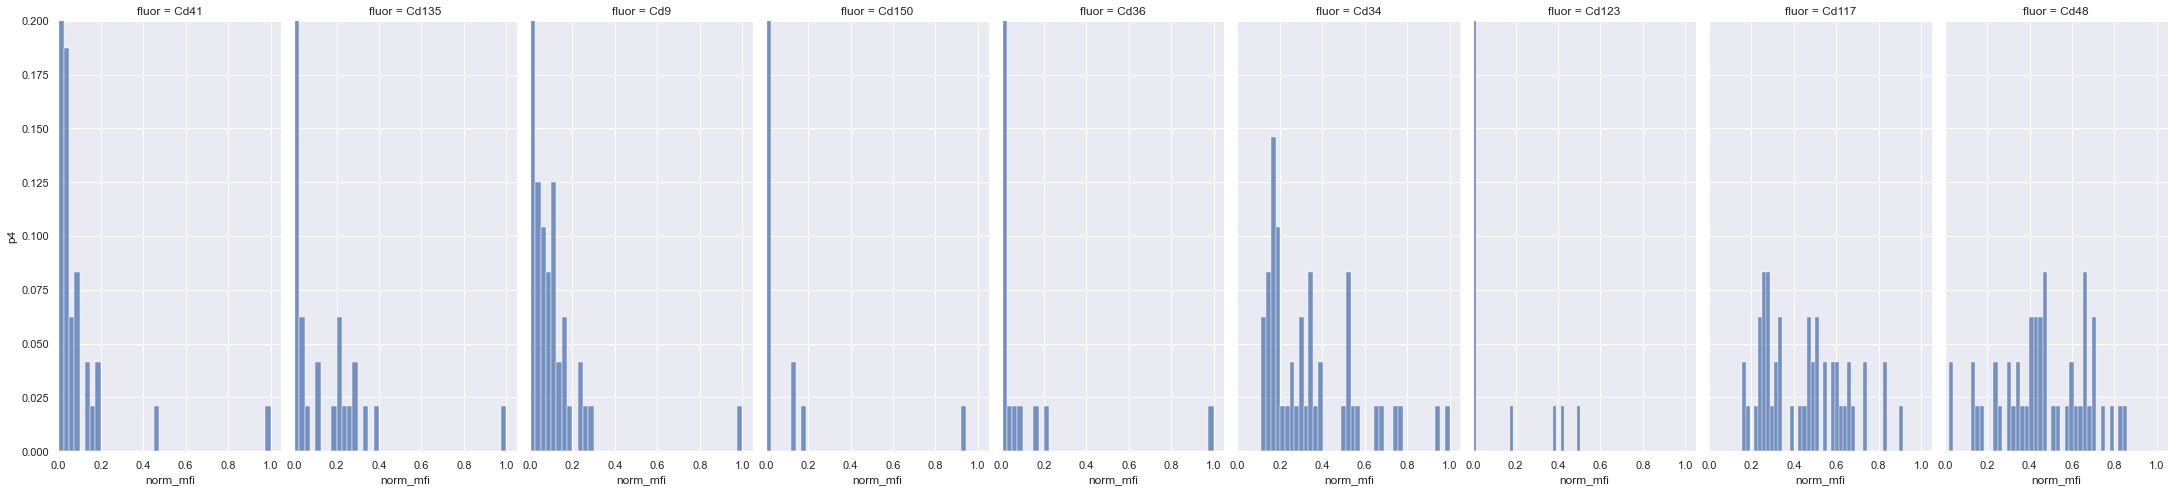

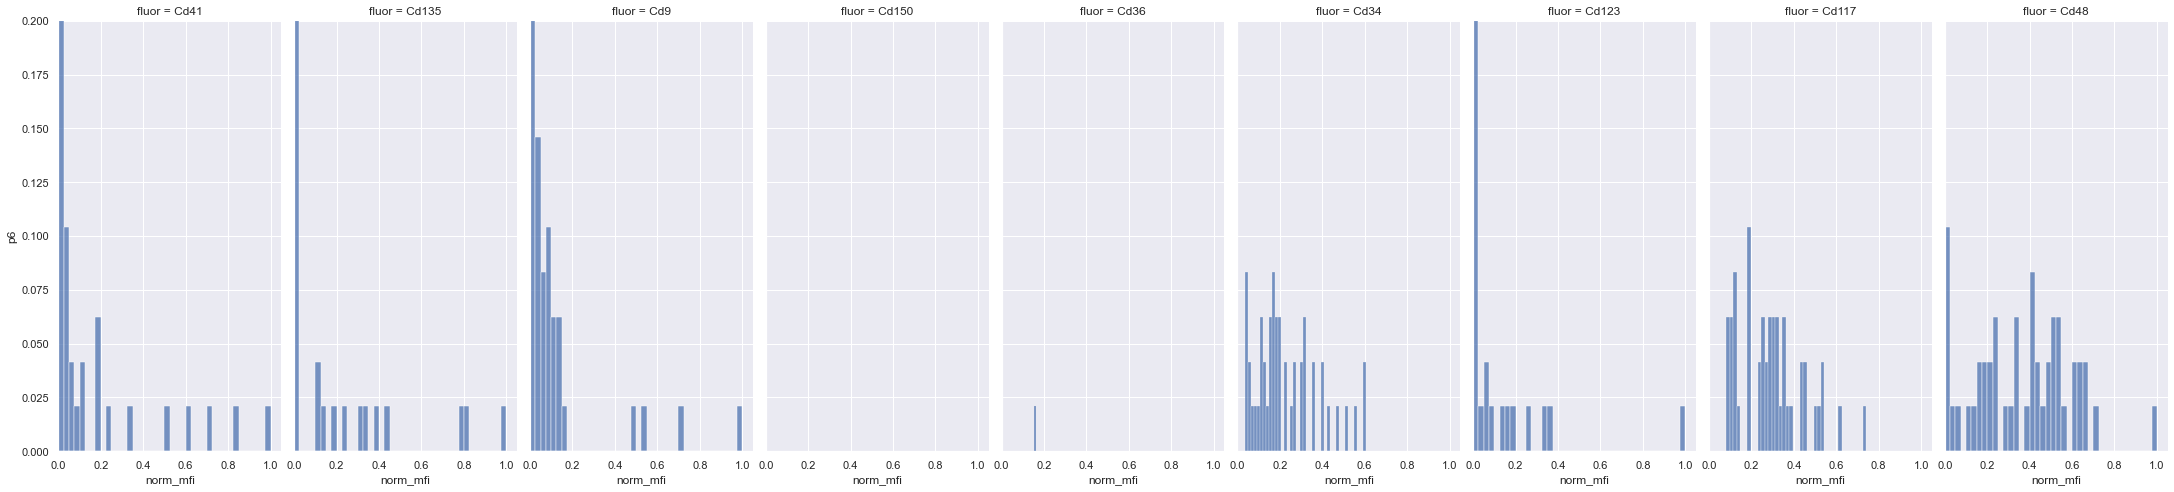

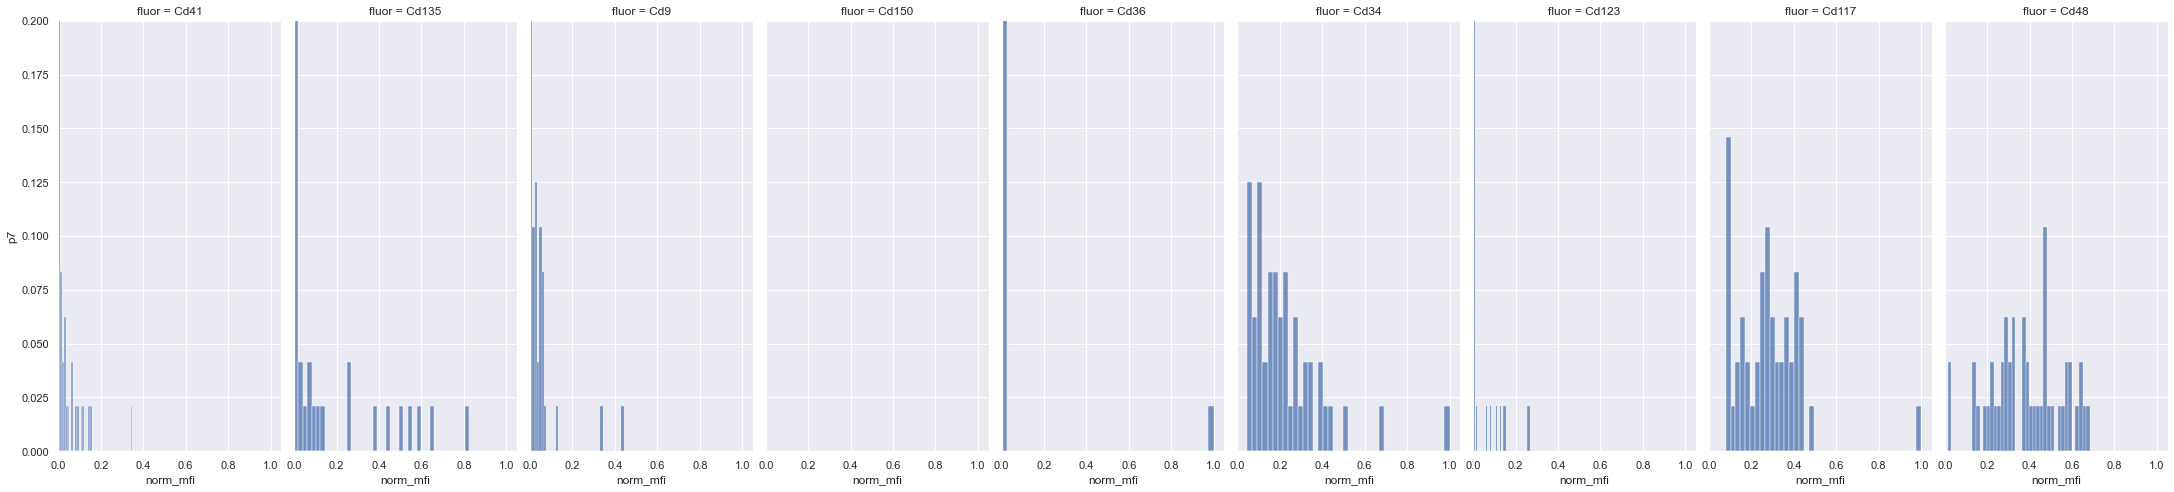

In [126]:
mfi_sortdate_by_pid = mfi_sortdate.groupby('pid')
for plate in mfi_sortdate_by_pid.groups.keys():
    plate_df = mfi_sortdate_by_pid.get_group(plate)
    plate_df = plate_df.drop(['Well', 'sortdate', 'plateid', 'pid'], axis = 1)
    plate_df = pd.melt(plate_df).rename(columns={'variable': 'fluor', 'value': 'norm_mfi'})
    
    # create figures
    g = sns.FacetGrid(plate_df, col = 'fluor')
    g.fig.set_size_inches(30, 7)
    g.map(sns.histplot, 'norm_mfi', bins = 40, stat = 'probability')
    g.set_axis_labels(y_var=plate)
    plt.xlim(left = 0)
    plt.ylim(top = 0.2)
    
    #save figures
    save_title = ''.join(('bkgd_norm_mfi-biomarkCells-', plate, '.png'))
    plt.savefig(save_title)



In [40]:
rdbu = sns.diverging_palette(250, 10, s = 100, l=50, sep = 1,  center= "dark", as_cmap=True)

In [41]:
mfi_norm = mfi_sortdate[['Cd41', 'Cd135', 'Cd9', 'Cd150', 'Cd36', 'Cd34', 'Cd123', 'Cd117', 'Cd48']].replace(np.nan, 0).copy()

#### Hierarchical clustering

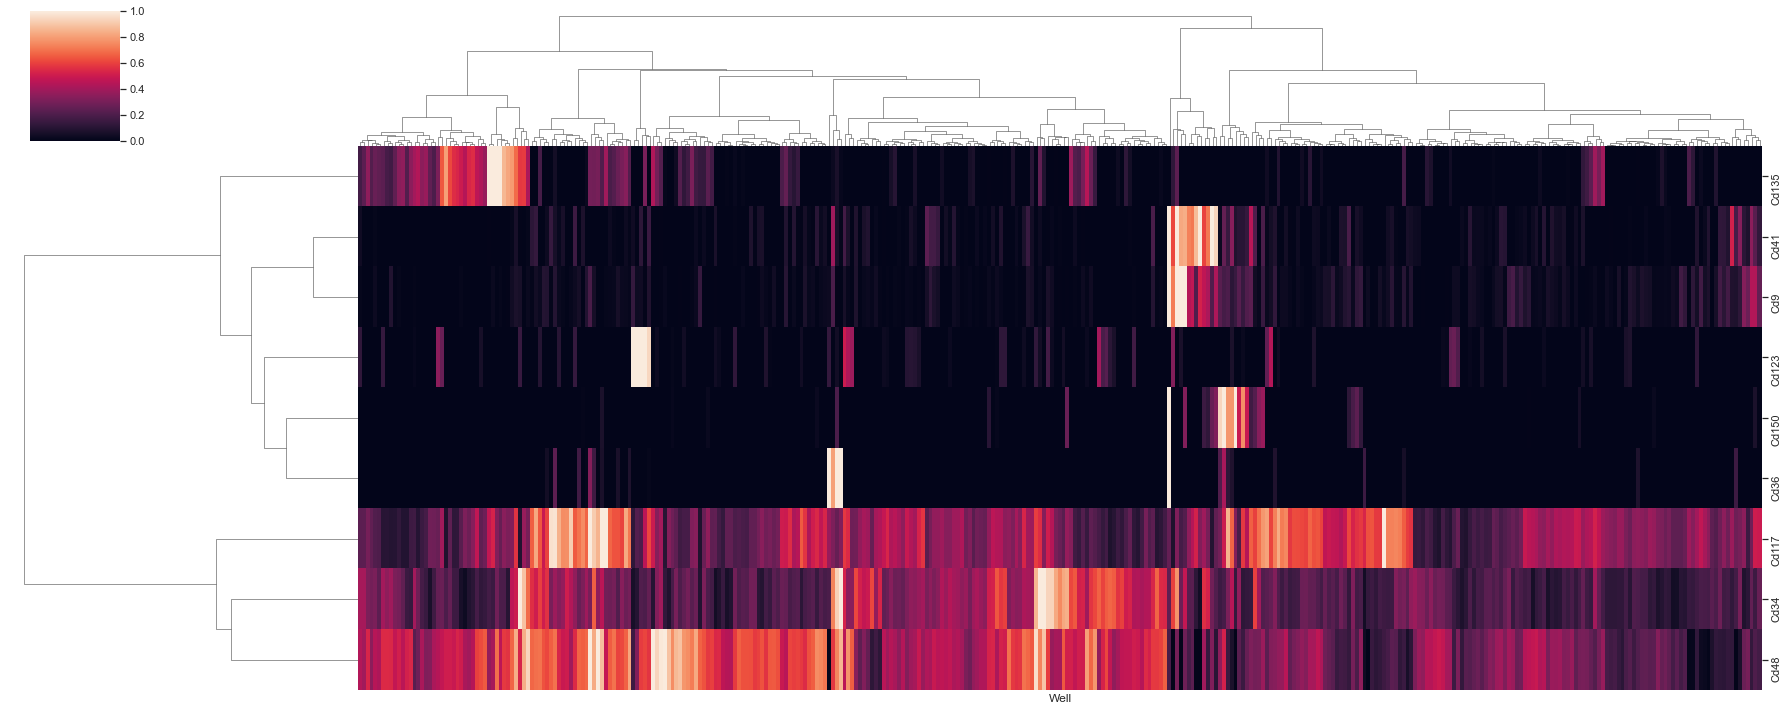

In [128]:
sns.clustermap(mfi_norm.transpose(), figsize=(25,10), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0, vmax = 1)

# Combine Biomark and MFI data

There are 2 ways to do this:  
> Combine the data then cluster, letting flow marker contribute to hierarchy  
> Cluster the biomark data, then tack on the appropriate flow markers  

Easiest should be to combine the data then cluster, so I'll start there

## Combine data

### Merge

Use `pd.merge(how = 'left')` to keep only indices from mfi_data that are also in biomark_ct

In [221]:
leading_zeros = re.compile('(?<=[a-z])0(?=[0-9])')
mfi_norm.index = mfi_norm.index.map(lambda x: re.sub(leading_zeros, '', x))
mfi_norm.columns = mfi_norm.columns.map(lambda x: x + 'pos')

In [222]:
combined_df = biomark_zscore.merge(mfi_norm, how='left', right_on=mfi_norm.index, left_index=True).drop("key_0", axis = 1)
combined_df.shape

(155, 84)

In [223]:
combined_df.head(3)

,AA467197,Actb,Aif1,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,Cd27,...,Vwf,Cd41pospos,Cd135pospos,Cd9pospos,Cd150pospos,Cd36pospos,Cd34pospos,Cd123pospos,Cd117pospos,Cd48pospos
Well,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,1.343368,1.984881,1.456208,0.000000,0.907335,1.709942,1.331599,1.673426,0.0,1.669990,...,1.557055,0.049922,0.0,0.002080,0.0,0.0,0.385930,0.000000,0.337471,0.456239
CMP_a2_p1,1.615076,0.000000,2.012236,1.270271,0.000000,1.604908,1.030103,1.404950,0.0,1.730810,...,1.129151,0.020482,0.0,0.023460,0.0,0.0,0.334980,0.101881,0.849703,0.536491
CMP_a4_p1,0.829461,1.127876,1.867833,0.931566,0.000000,1.048409,2.243835,2.045571,0.0,1.706885,...,0.948649,0.125845,0.0,0.174842,0.0,0.0,0.279741,0.000000,0.281205,0.119243


In [224]:
combined_df = combined_df.transpose()

### Hierarchical cluster

#### Combined cluster:  co-sort

Cluster on biomark and mfi; mfi distributed through rows

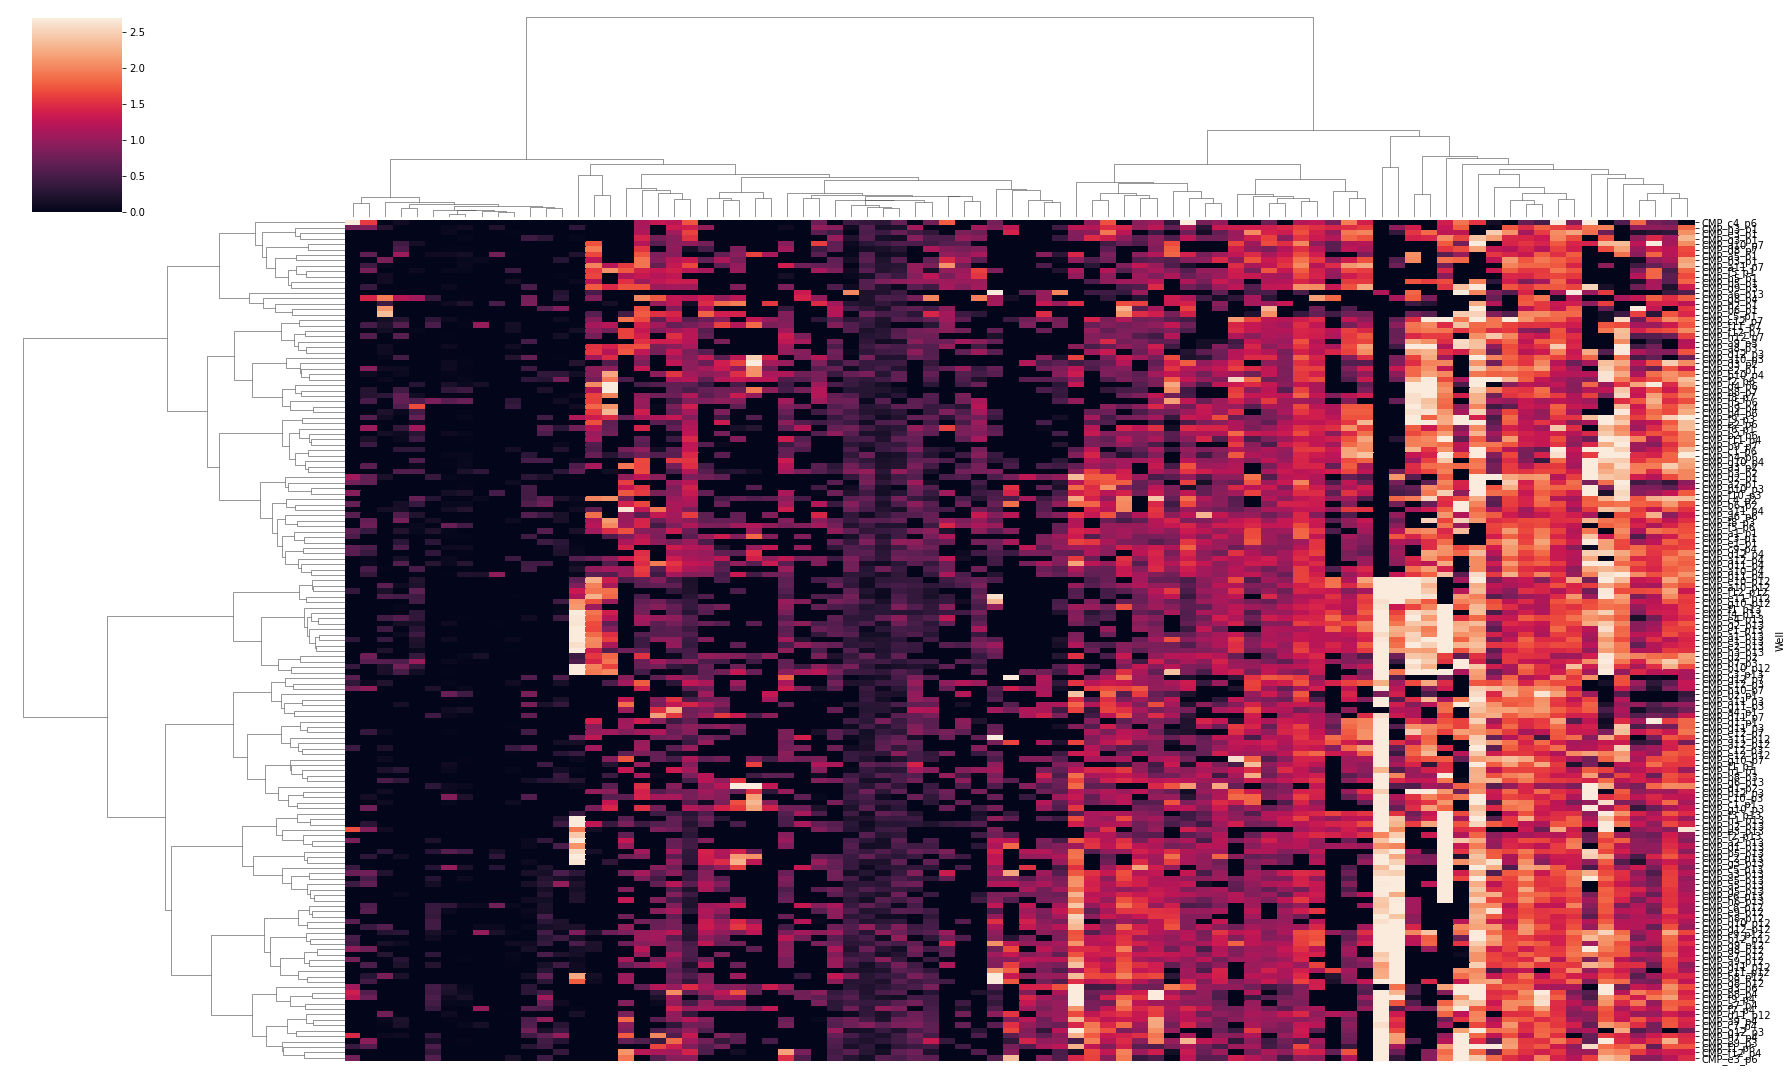

In [244]:
sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True)

#### Combined cluster: separated

Cluster on biomark and mfi; plot with biomark on top and mfi on bottom

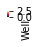

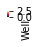

In [245]:
hm_rows = sns.clustermap(combined_df, figsize=(.5,.5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(combined_df, figsize=(.5, .5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered biomark

In [246]:
row_order = []
for pos in hm_rows:
    newrow = combined_df.index[pos]
    row_order.append(newrow)
biomark_order = [x for x in row_order if not x.endswith('pos')]
mfi_order = [x for x in row_order if x.endswith('pos')]
combined_biomark = combined_df[combined_df.index.isin(biomark_order)]
combined_mfi = combined_df[combined_df.index.isin(mfi_order)]

get cell order from clustered biomark

In [247]:
col_order = []
for pos in hm_cols:
    newcol = combined_df.columns[pos]
    col_order.append(newcol)

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


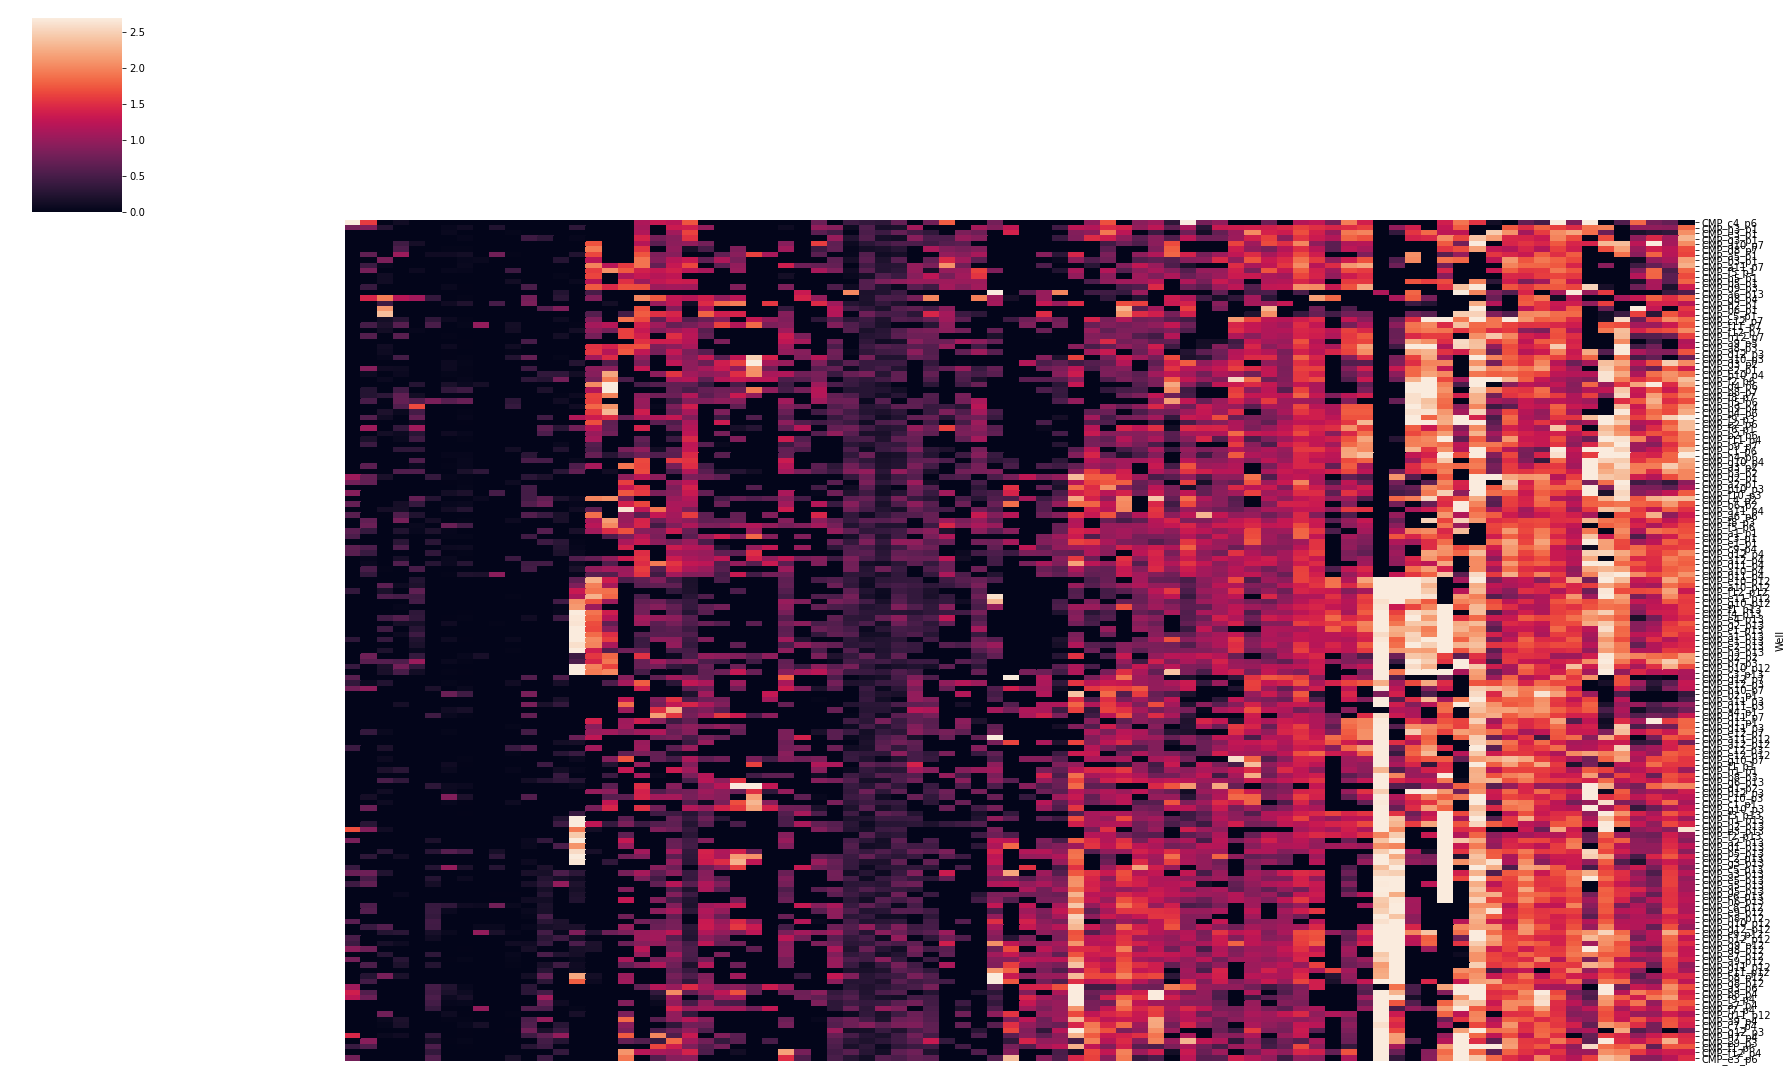

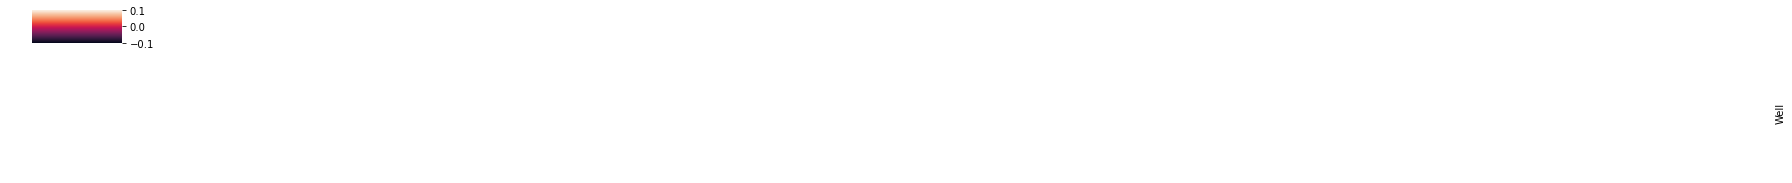

In [248]:
sns.clustermap(combined_biomark.reindex(index = biomark_order, columns=col_order), figsize = (25, 15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster = False)
sns.clustermap(combined_mfi.reindex(index = mfi_order, columns=col_order), figsize = (25, 2.5), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster = False)

### Exclude plate 2

Plate 2 may be an outlier. Exclude those.

In [249]:
combined_df = biomark_zscore.merge(mfi_norm, how='left', right_on=mfi_norm.index, left_index=True).drop("key_0", axis = 1)
combined_df.shape

(155, 84)

#### remove p2 wells

In [250]:
combined_nop2 = combined_df[~combined_df.index.str.endswith('_p2')].copy().transpose()
combined_nop2.shape

(84, 148)

#### Combined cluster:  co-sort

Cluster on biomark and mfi; mfi distributed through rows

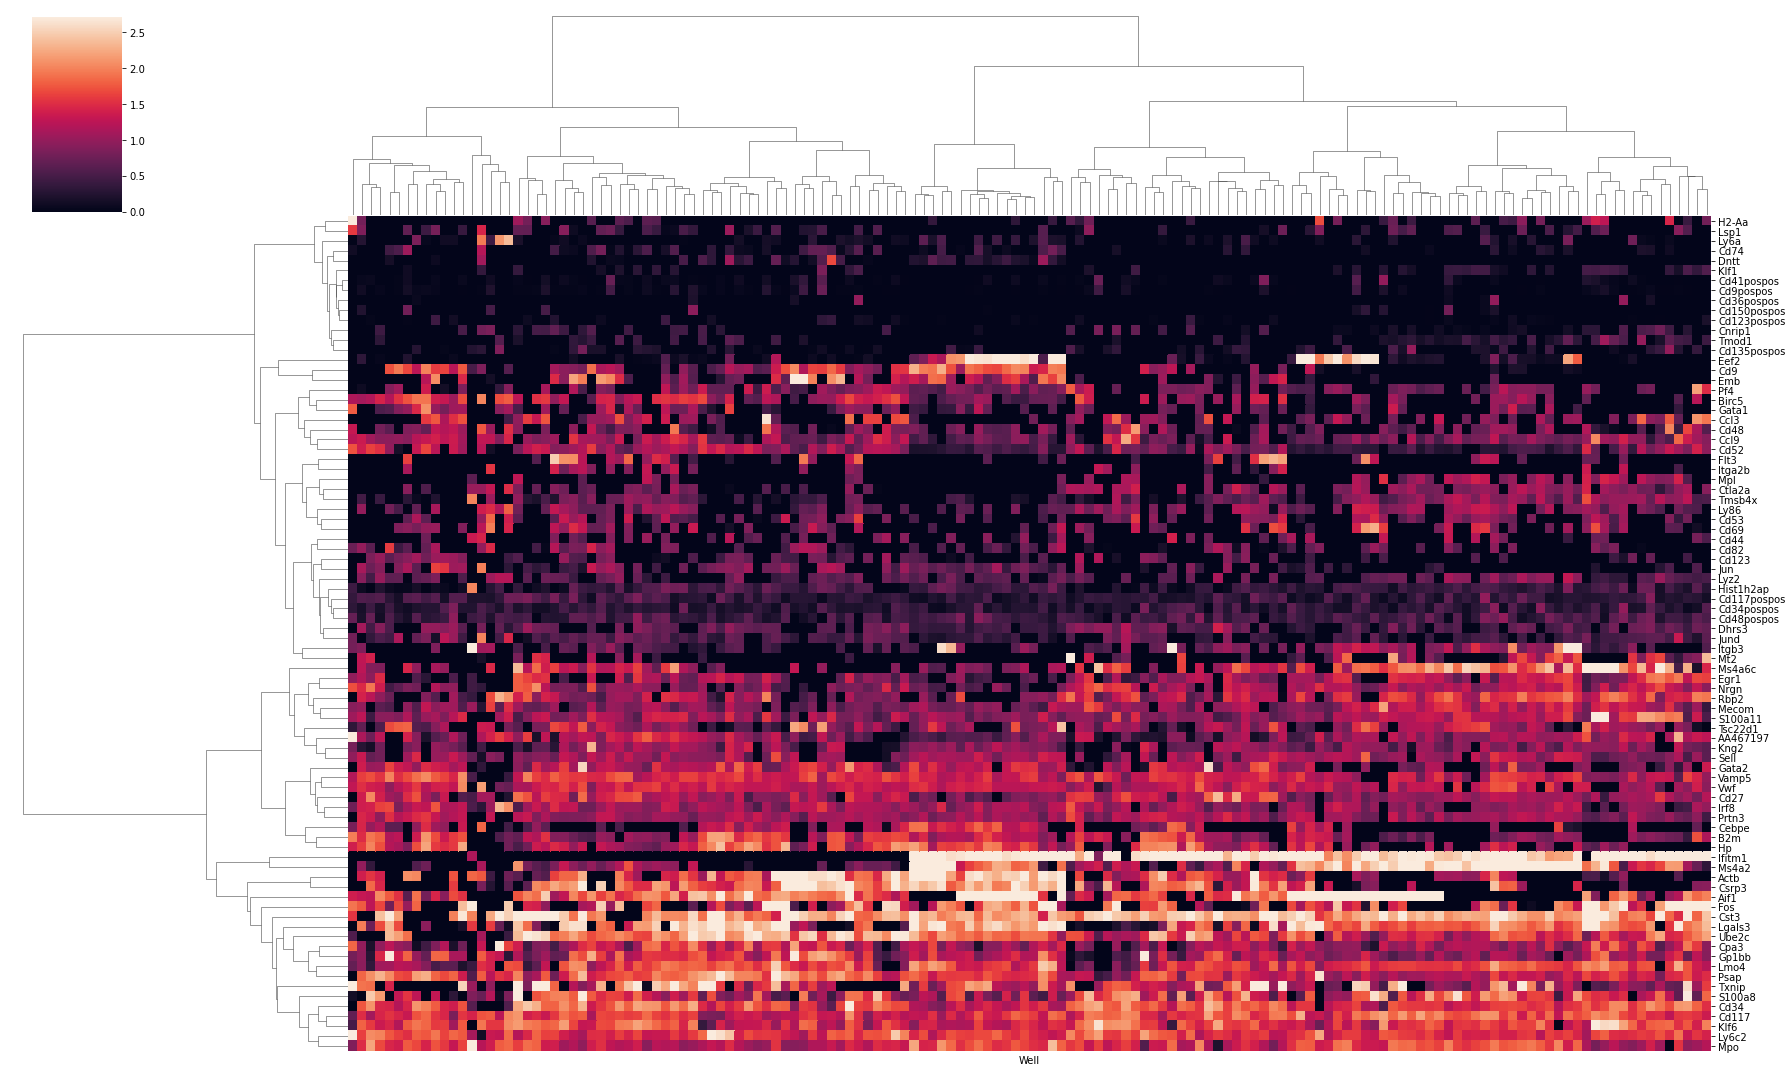

In [251]:
sns.clustermap(combined_nop2, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True)

#### Combined cluster: separated

Cluster on biomark and mfi; plot with biomark on top and mfi on bottom

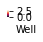

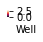

In [252]:
hm_rows = sns.clustermap(combined_nop2, figsize=(.5,.5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(combined_nop2, figsize=(.5, .5), method = 'ward', robust = True, xticklabels = False, yticklabels = False, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered biomark

In [253]:
row_order = []
for pos in hm_rows:
    newrow = combined_nop2.index[pos]
    row_order.append(newrow)
biomark_order = [x for x in row_order if not x.endswith('pos')]
mfi_order = [x for x in row_order if x.endswith('pos')]
combined_biomark = combined_nop2[combined_nop2.index.isin(biomark_order)]
combined_mfi = combined_nop2[combined_nop2.index.isin(mfi_order)]

get cell order from clustered biomark

In [254]:
col_order = []
for pos in hm_cols:
    newcol = combined_nop2.columns[pos]
    col_order.append(newcol)

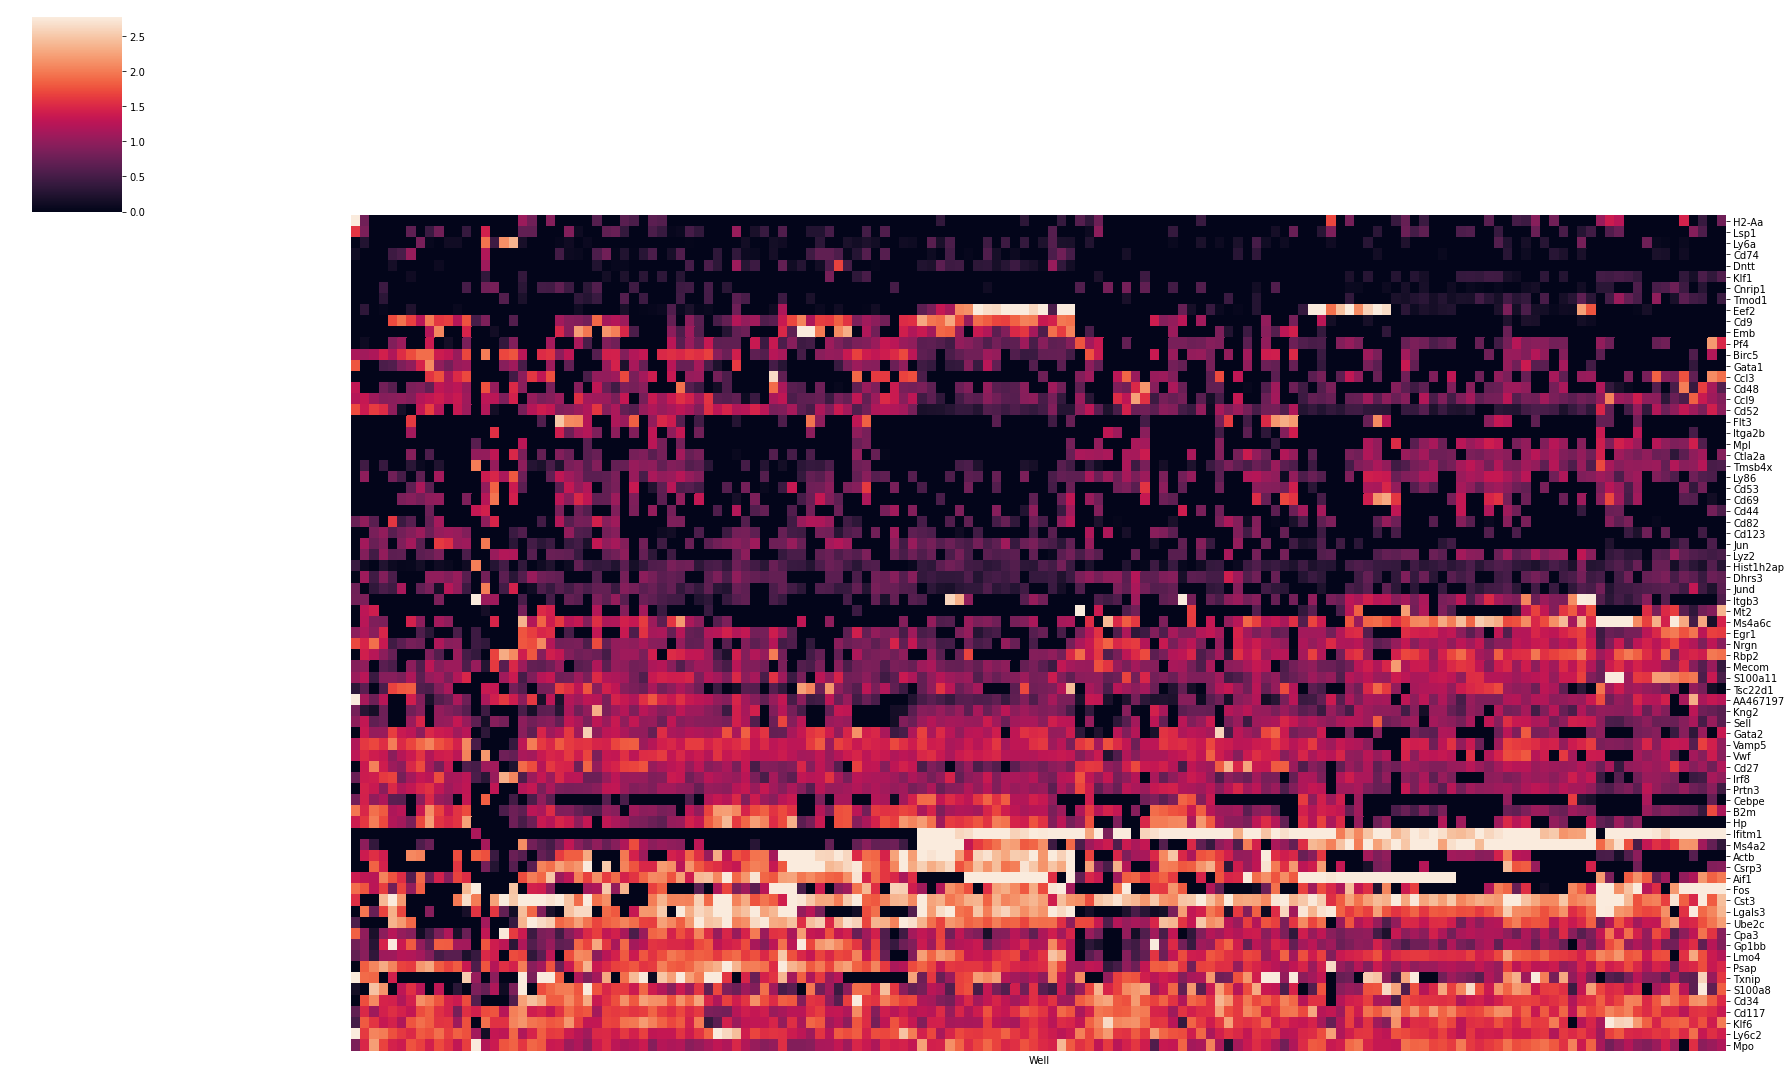

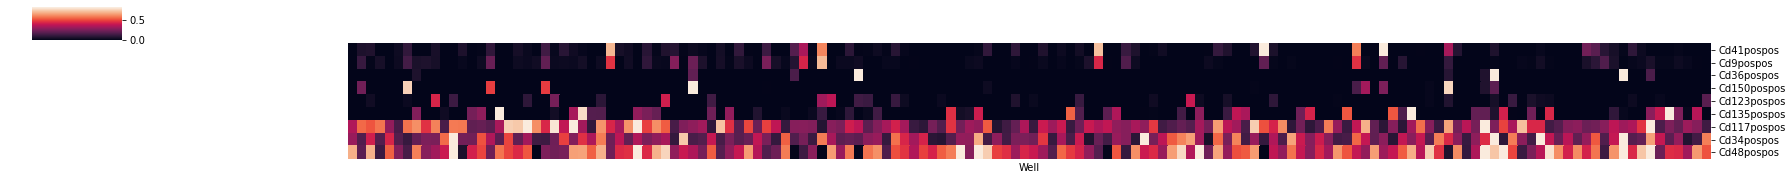

In [260]:
sns.clustermap(combined_biomark.reindex(index = biomark_order, columns=col_order), figsize = (25, 15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster=False)
sns.clustermap(combined_mfi.reindex(index = mfi_order, columns = col_order), figsize = (25, 2.5), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster = False)

## Cluster columns and rows then add mfi

### get column and row order

*remember: `biomark` = `biomark_zscore.transpose()`

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


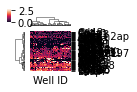

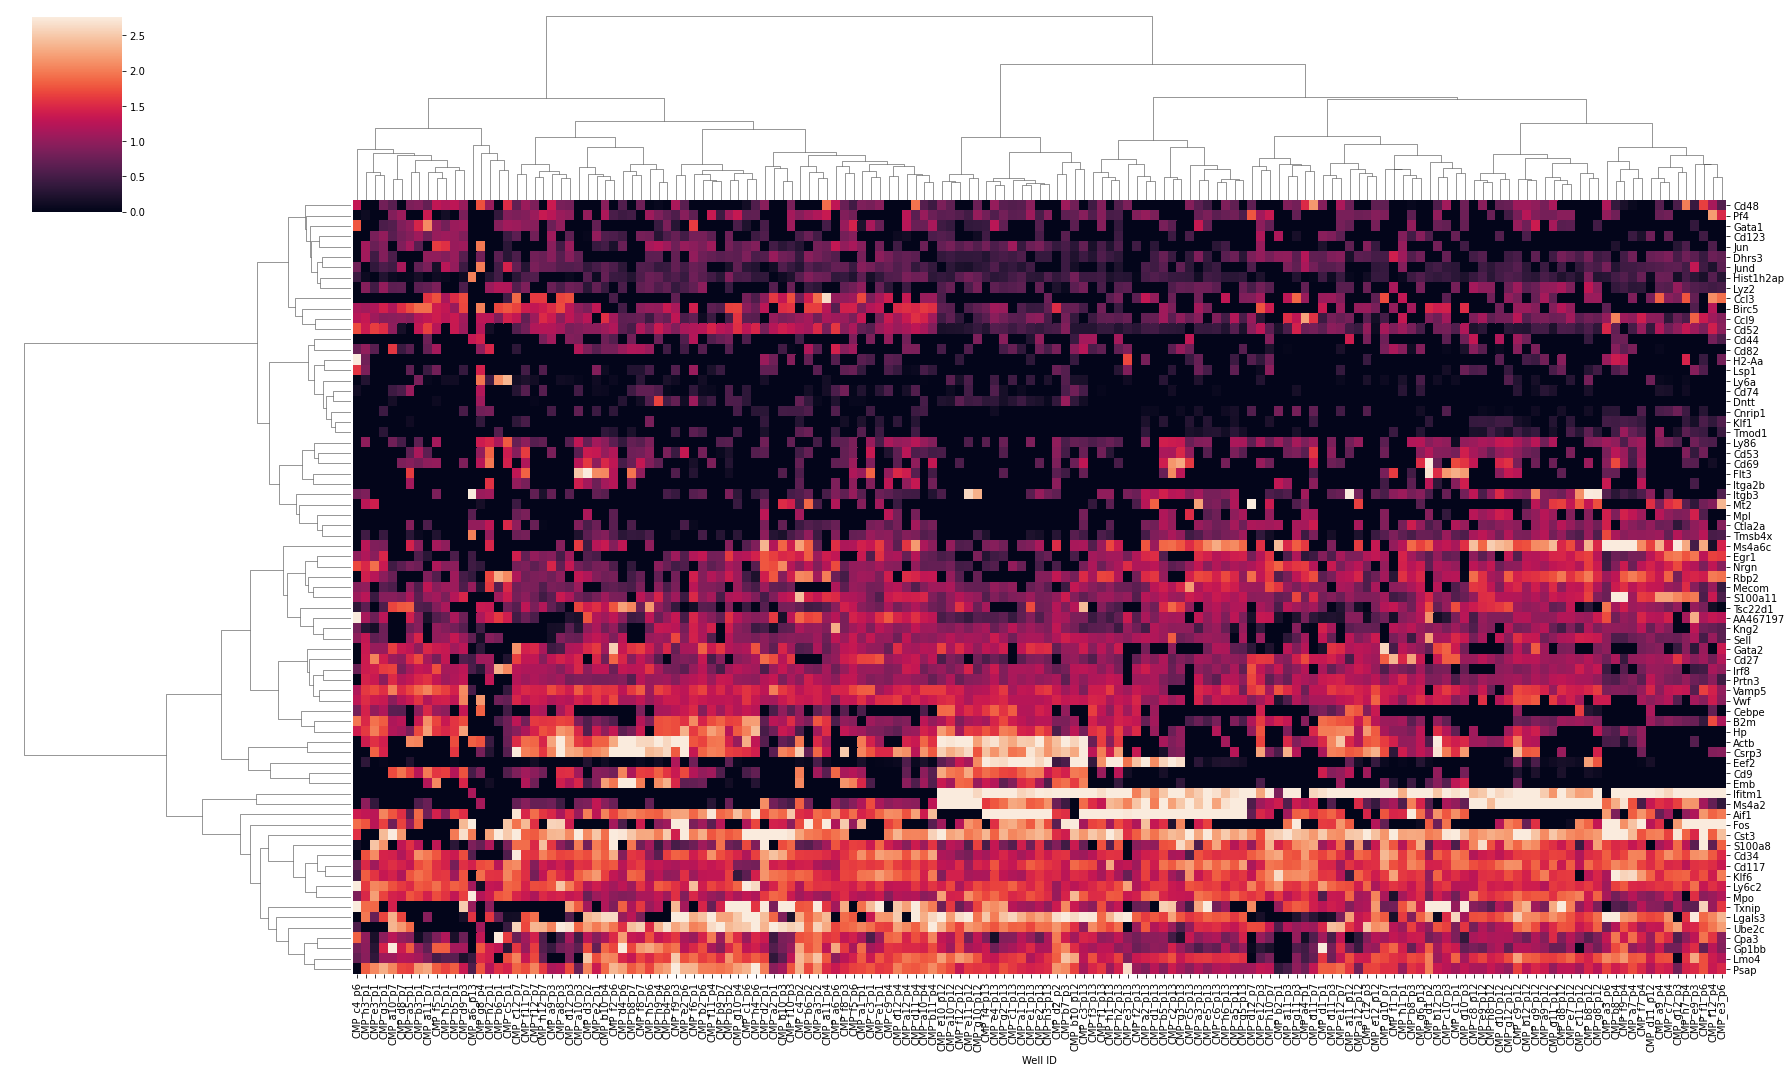

In [288]:
hm_rows = sns.clustermap(biomark, figsize=(1,1), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0).dendrogram_row.reordered_ind
hm_cols = sns.clustermap(biomark, figsize=(25,15), method = 'ward', robust = True, xticklabels = True, yticklabels = True, vmin = 0).dendrogram_col.reordered_ind

get the gene order from clustered biomark

In [289]:
row_order = []
for pos in hm_rows:
    newrow = biomark.index[pos]
    row_order.append(newrow)

get cell order from clustered biomark

In [290]:
col_order = []
for pos in hm_cols:
    newcol = biomark.columns[pos]
    col_order.append(newcol)

reorder mfi columns to match biomark order

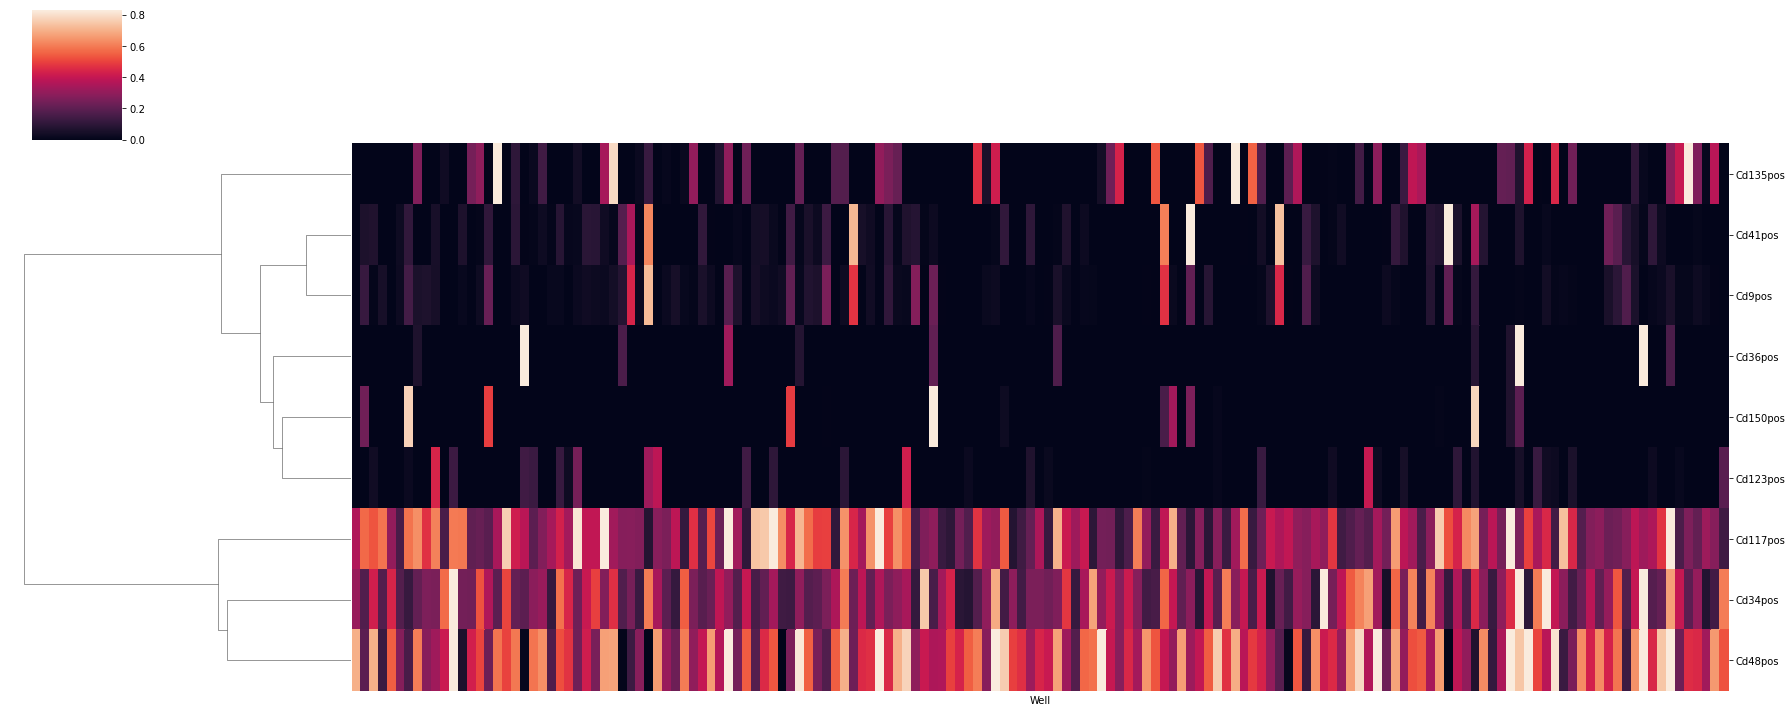

In [293]:
sns.clustermap(mfi_norm.transpose().reindex(columns=col_order), figsize=(25,10), method = 'ward', robust = True, xticklabels = False, yticklabels = True, col_cluster=False)

### Do the whole thing in one df

In [294]:
combined_df = biomark.reindex(index=row_order, columns=col_order).append(mfi_norm.transpose().reindex(columns=col_order), sort=False)

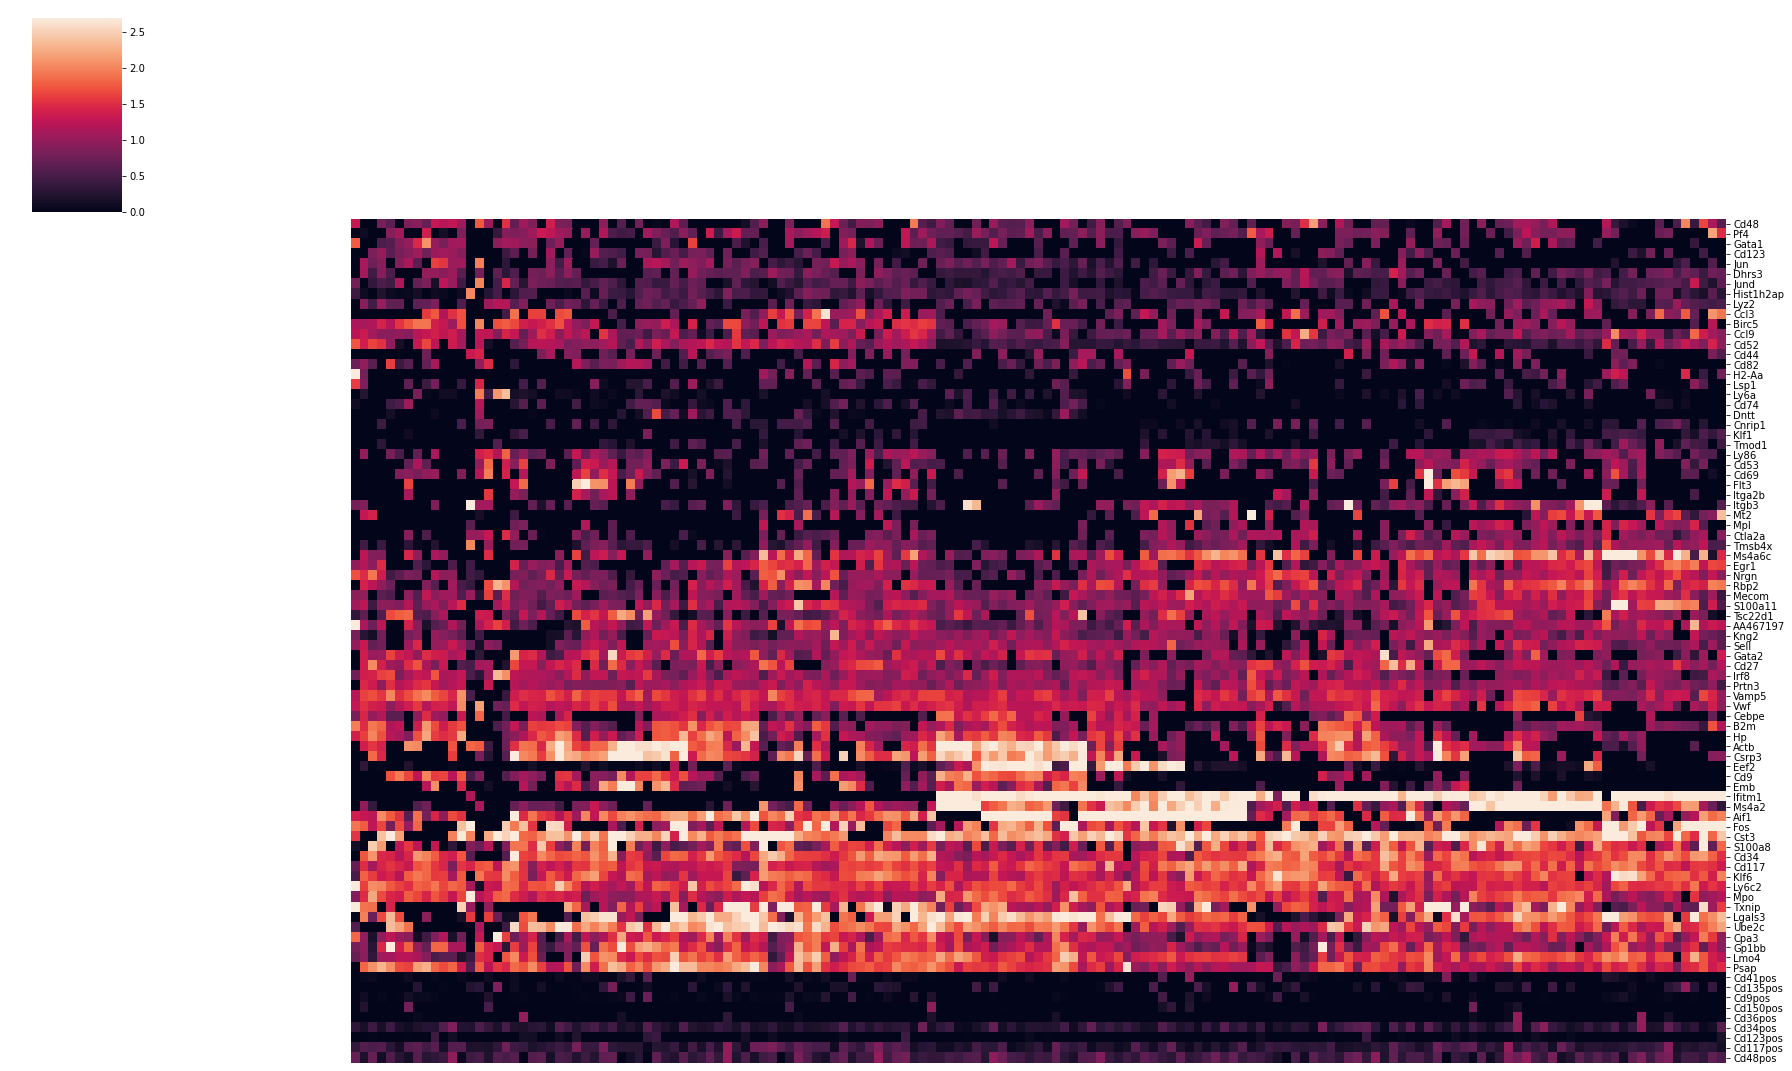

In [295]:
sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=False, col_cluster=False)

Because gene range is 0 to +infinity, and because marker range is -infinity to +infinity, graphing them on the same heatmap really throws off the colors. Will plot with Biomark heatmap and cell-reordered MFI heatmap (see powerpoint).

## Cluster rows-only then add MFI

Another way to do it is to cluster by genes, add the MFI, and let the columns cluster using both gene expression *and* mfi

### get column and row order

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


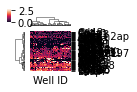

In [296]:
hm_rows = sns.clustermap(biomark, figsize=(1,1), method = 'ward', robust = True, xticklabels = False, yticklabels = True, vmin = 0).dendrogram_row.reordered_ind

get the gene order from clustered biomark

In [297]:
row_order = []
for pos in hm_rows:
    newrow = biomark.index[pos]
    row_order.append(newrow)

get cell order from clustered biomark

In [298]:
col_order = []
for pos in hm_cols:
    newcol = biomark.columns[pos]
    col_order.append(newcol)

### Do the whole thing in one df

combine the Biomark and MFI dfs, preserving Biomark's gene row_order. Also reindex columns in both to col_order to make sure they append properly

In [299]:
combined_df = biomark.reindex(index=row_order, columns=col_order).append(mfi_norm.transpose().reindex(columns=col_order), sort=False)

Now plot combined df to get column order

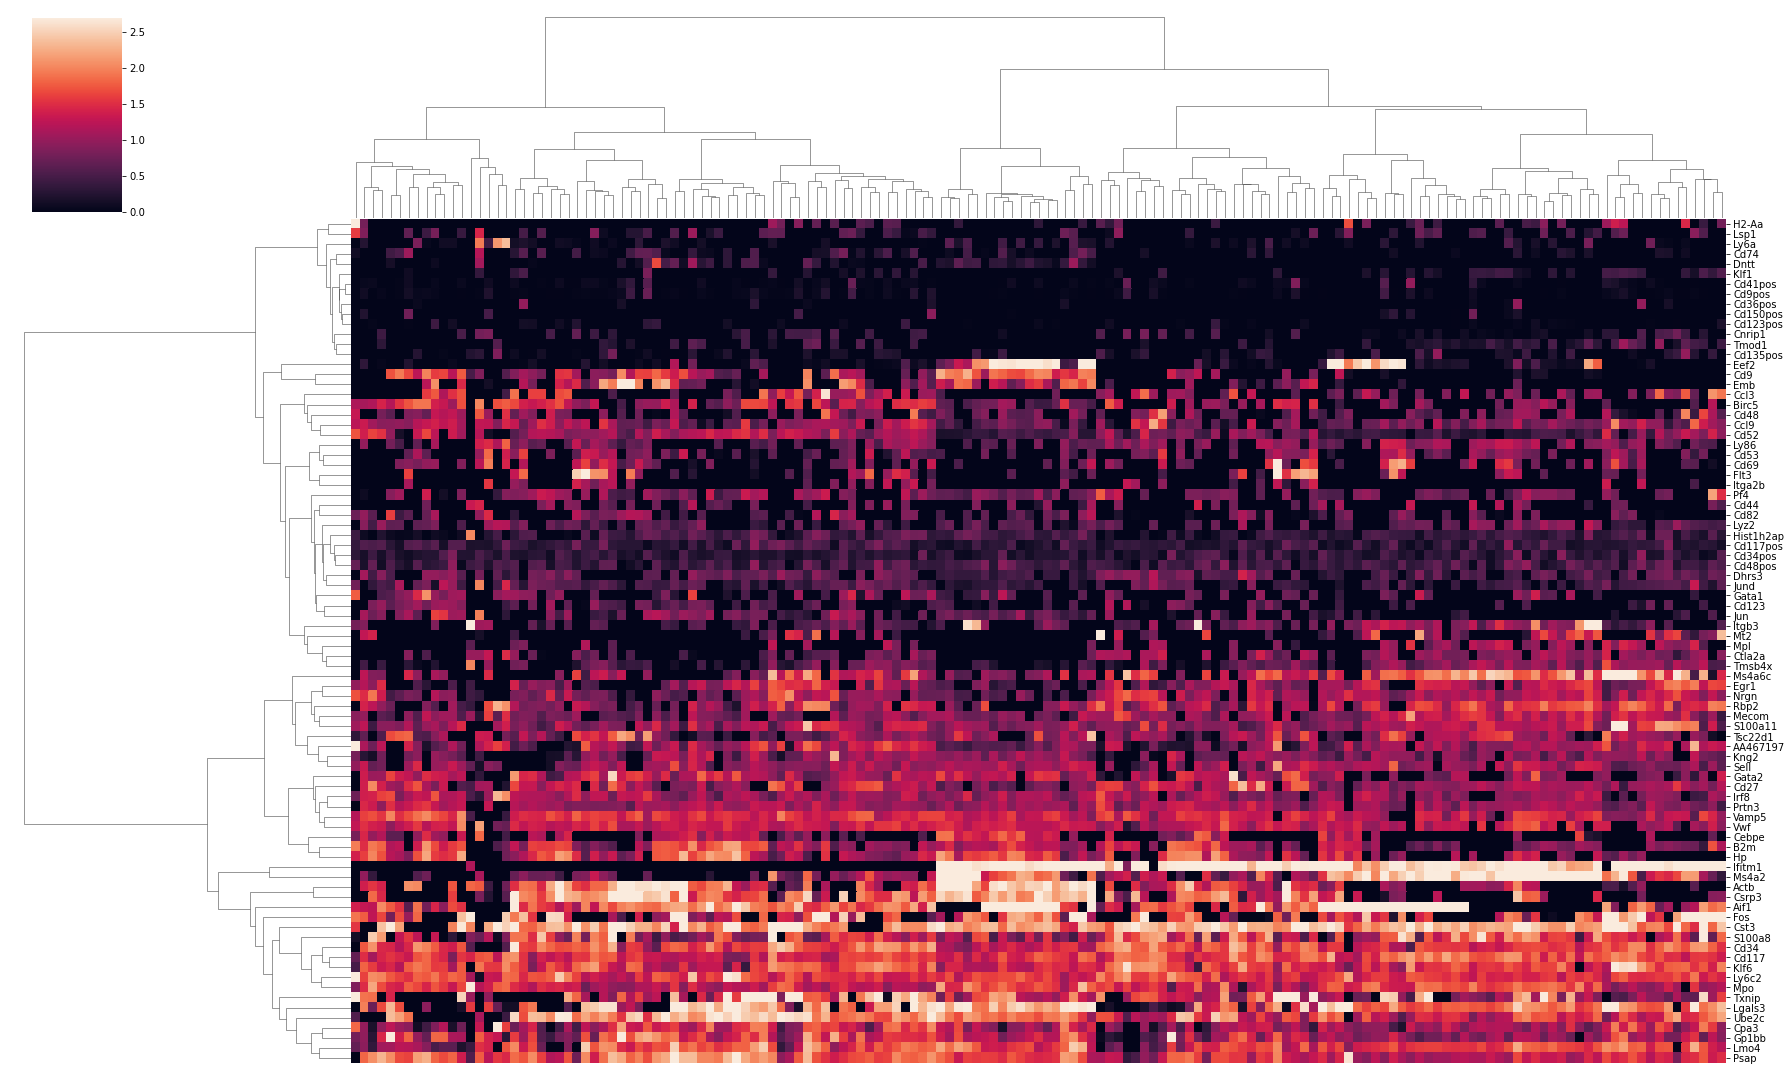

In [300]:
combined_cols = sns.clustermap(combined_df, figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, row_cluster=True, col_cluster=True).dendrogram_col.reordered_ind

Get cell order from combined clustered df (`combined_cols` is ordered by position, not cell ID)

In [301]:
col_order = []
for pos in combined_cols:
    newcol = biomark.columns[pos]
    col_order.append(newcol)

Great! Now to make the two pictures, plot biomark and MFI separately, letting the rows in each cluster but preventing column clustering

reorder Biomark columns to match combined_df

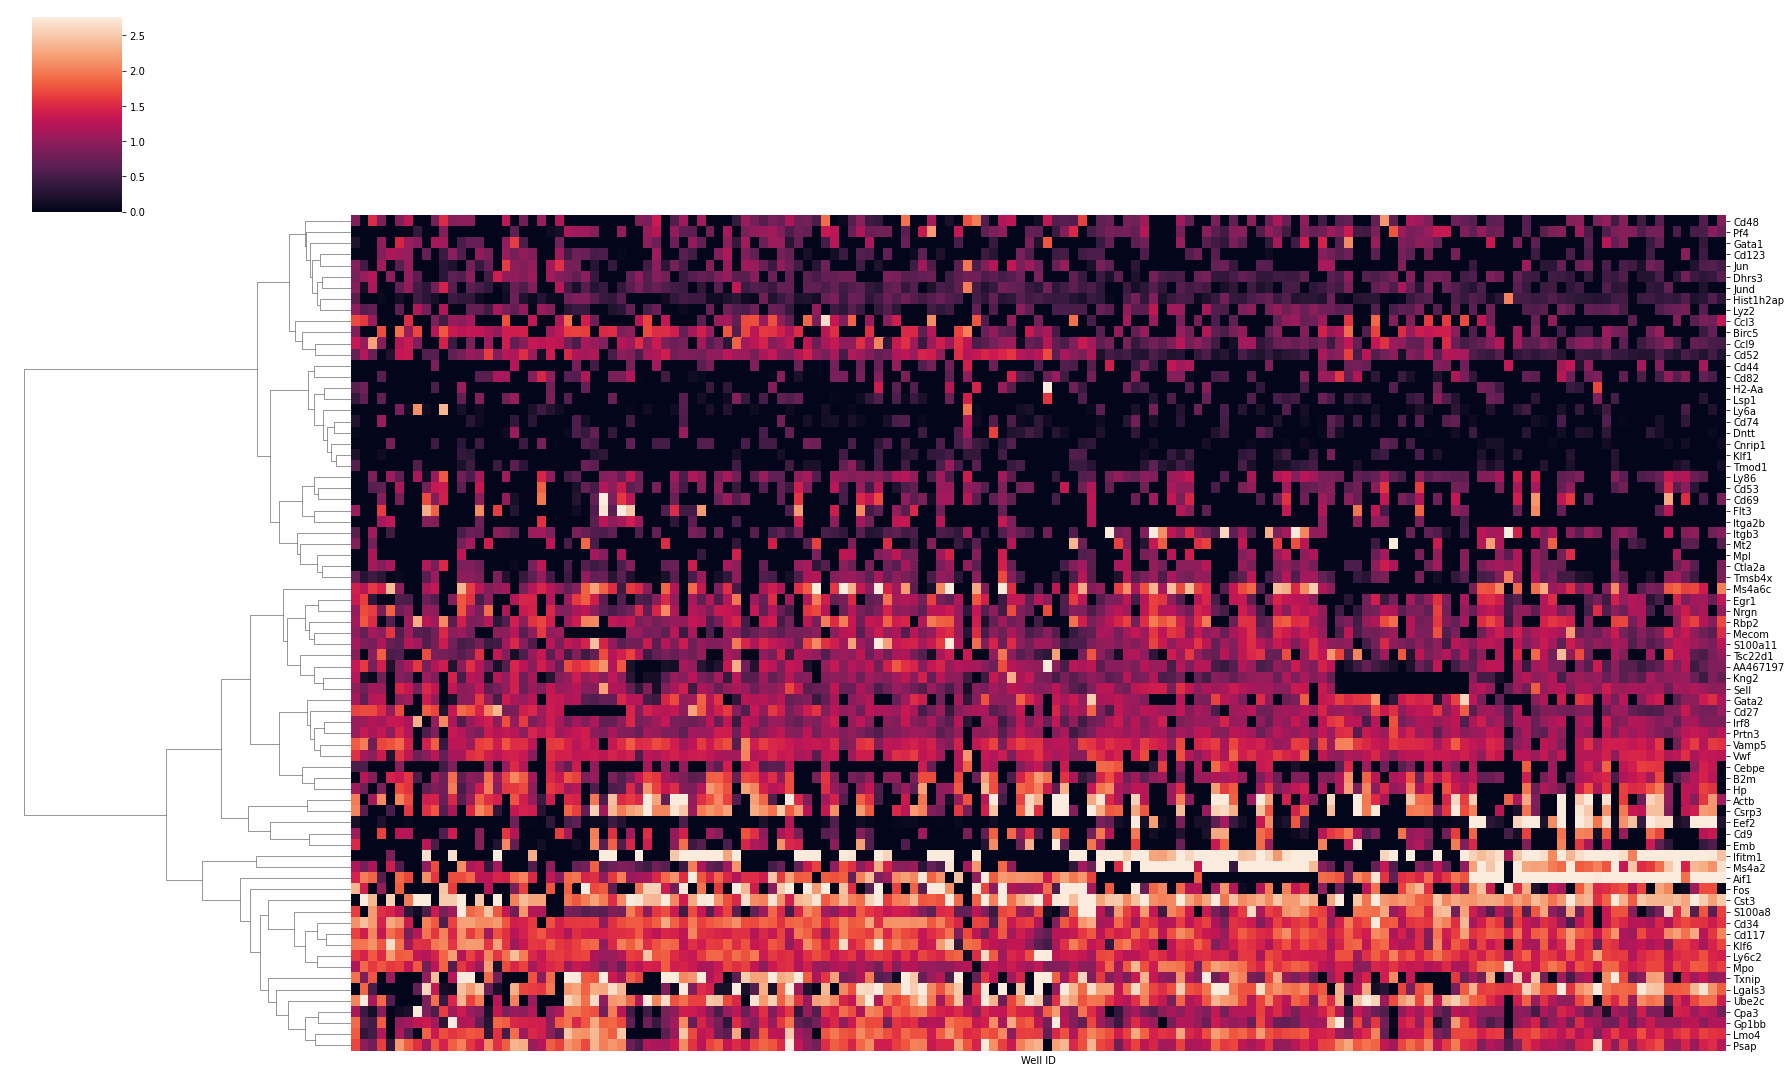

In [302]:
sns.clustermap(biomark.reindex(columns=col_order), figsize=(25,15), method = 'ward', robust = True, xticklabels = False, yticklabels = True, col_cluster=False, row_cluster = True)

reorder mfi_norm columns to match combined_df

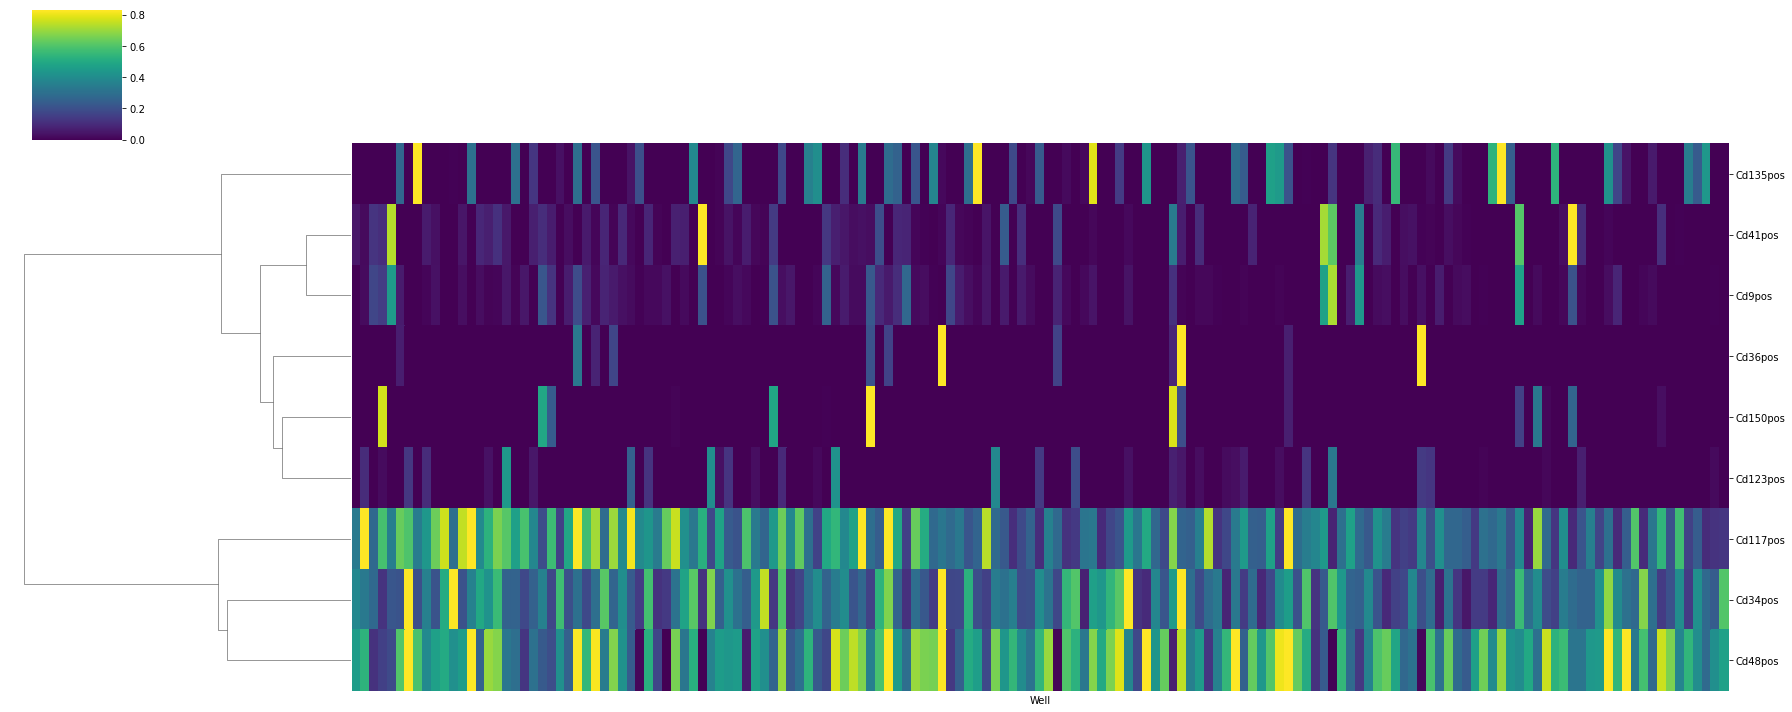

In [304]:
sns.clustermap(mfi_norm.transpose().reindex(columns=col_order), figsize=(25,10), method = 'ward', robust = True, xticklabels = False, yticklabels = True, cmap = 'viridis', col_cluster=False, row_cluster = True)

<a id='PlottSNEData'></a>

# Plotting Data as tSNE

## tSNE of LSK, CMP, and MEP

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
lsk_ctTrimmed = biomark_ctrimmed.filter(regex = 'LSK')
cmp_ctTrimmed = biomark_ctrimmed.filter(regex = 'CMP')
mep_ctTrimmed = biomark_ctrimmed.filter(regex = 'MEP')

In [ ]:
# cmp_tsne = cmp_ctTrimmed.transpose()
cmp_tsne = cmp_ctTrimmed
cmp_array = cmp_tsne.to_numpy()
# array
cmp_fit = tsne.fit_transform(cmp_array)
cmp_target_names = cmp_tsne.index
cmp_target_ids = range(len(cmp_target_names))
# target_ids
cmp_target_names
plt.figure(figsize=(16,10))
plt.scatter(x=cmp_fit[:,0], y=cmp_fit[:,1], c = sns.color_palette(n_colors = 97))
plt.legend()
plt.title("CMP_Probe_tSNE - each dot is a biomarkprobe")

In [ ]:
df = cmp_alldata

In [ ]:
pca = PCA(n_components=3)
pca.fit(df)

In [ ]:
result = pd.DataFrame(pca.transform(df) ,columns=['PCA%i' % i for i in range(3)], index=df.index)

In [ ]:
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], cmap="Set2_r", s=100)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on CMP probe and fluorophore data")
plt.show()

## pca of all probe data

In [ ]:
biomark_ct = pd.read_excel("BiomarkExcels/20181023_BiomarkRun.xlsx", sheet_name="AllBioMarkStats")
celltypes = biomark_ct[['Well ID', 'Cell ID']]
celltypes = celltypes.drop_duplicates()
celltypes = celltypes.set_index('Well ID').sort_index()
celltypes.head(3)

In [ ]:
celltypes['categorical']= pd.Categorical(celltypes['Cell ID'])
my_color = celltypes['categorical'].cat.codes
# my_color

In [ ]:
all_probes = biomark_ctIndexed.transpose()
all_probes.head(3)

In [ ]:
df = all_probes
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c = my_color, cmap="Set2_r", s=100)
ax.legend(('LSK', 'CMP'))

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on CMP probe and fluorophore data")

plt.show()

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c = my_color, cmap="jet", s=100)
ax.legend(('LSK', 'CMP'))

<a id='20190809'></a>

# Normalization Notes

[Bioconductor Support Article](https://support.bioconductor.org/p/34182/)

Other approaches

[Published data analysis for 96.96 Dynamic Array IFC](https://www.gene-quantification.de/livak-methods-59-transcriptional-biomarkers-2013.pdf)  
* Data analyzed using Fluidigm Real-Time PCR Analysis software  
    * Used linear (derivative) baseline correction method  
    * Used Auto (global) Ct threshold method (alt. 0.01)
    * Ct range 12 - 28 cycles
    * Export Cq values  

[G. Guo, Dev. Cell; 18 (2010) 675–685.](https://www.sciencedirect.com/science/article/pii/S1534580710001103#sec4)
* Relative expression determined by subtracting Ct value from "assumed baseline of 28"
* Remove cells with absent/low endogenous controls (~10%)
* Normalize these by subtracting average of ActB+GAPDH expression levels

[geNorm method](https://doi.org/10.1186/gb-2002-3-7-research0034)
* Average control genes using __geometric mean__ (not arithmatic mean)
    * genorm support stops with python 2.7 
    * R may have an implementation for it via [NormqPCR](https://www.bioconductor.org/packages/release/bioc/html/NormqPCR.html)
    
[ERgene](https://www.nature.com/articles/s41598-020-75586-5)
* Python library to for gene nomralization [github](https://github.com/Starlitnightly/ERgene)

[Beth Psaila's Approach](https://doi.org/10.1186/s13059-016-0939-7)
* Exclude assays with:
    * LOD (limit of detection) >= 40
* Exclude cells with:
    * >70 failed assays
    * B2M >= 13
    * GAPDH >= 15
    * Cells with mean Ct > 20
* Norm to average of [B2M & GAPDH]
* Expression = 2^-(NormCt)
* Exclude HKgenes

Going with Beth's method because it's the most thoroughly described.
Might also gofor quantile nomrlization